In [24]:
!git clone https://github.com/anaynasingh/acne04-dataset

fatal: destination path 'acne04-dataset' already exists and is not an empty directory.


In [25]:
import os
dataset_path = 'acne04-dataset'
print(os.listdir(dataset_path))


['.git', 'Classification', 'Detection', 'README.md']


custom dataset class

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET

class AcneDataset(Dataset):
    def __init__(self, images_dir, xml_dir, label_files, transform=None):
        self.images_dir = images_dir
        self.xml_dir = xml_dir
        self.transform = transform
        self.labels = self.parse_labels(label_files)
        self.image_files = list(self.labels.keys())
    
    def __len__(self):
        return len(self.image_files)
    
    def criterion(self, lesions_num):
        """Calculate severity grade based on lesion count"""
        lesions_num = int(lesions_num)
        if lesions_num <= 5:
            return 0  # Clear skin
        elif lesions_num <= 15:
            return 1  # Almost clear
        elif lesions_num <= 25:
            return 2  # Mild severity
        elif lesions_num <= 45:
            return 3  # Moderate severity
        else:
            return 4  # Severe
    
    def __getitem__(self, idx):
        """Get image, detection targets, and severity information"""
        image_name = self.image_files[idx]
        image_base_name = os.path.splitext(image_name)[0]
        
        # Load image
        img_path = os.path.join(self.images_dir, image_name)
        xml_path = os.path.join(self.xml_dir, f"{image_base_name}.xml")
        image = Image.open(img_path).convert("RGB")
        
        # Parse annotations
        boxes, (width, height) = self.parse_annotation(xml_path)
        
        # Prepare detection targets
        target = {}
        bboxes = []
        labels = []
        
        for box in boxes:
            xmin, ymin, xmax, ymax = box["bbox"]
            bboxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.labels[image_name]['acne_type'])

        # Create complete target dictionary
        target["boxes"] = torch.as_tensor(bboxes, dtype=torch.float32)
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["lesion_count"] = self.labels[image_name]['lesion_count']
        target["severity_grade"] = self.labels[image_name]['severity_grade']
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

    def parse_labels(self, label_files):
        """Parse label files and calculate severity grades"""
        labels = {}
        for label_file in label_files:
            with open(label_file, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    image_name = parts[0]
                    acne_type = int(parts[1])
                    lesion_count = int(parts[2])
                    severity_grade = self.criterion(lesion_count)
                    labels[image_name] = {
                        'acne_type': acne_type,
                        'lesion_count': lesion_count,
                        'severity_grade': severity_grade
                    }
        return labels

    def parse_annotation(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        boxes = []
        size = root.find("size")
        width = int(size.find("width").text)
        height = int(size.find("height").text)
        
        for obj in root.findall("object"):
            label = obj.find("name").text
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            boxes.append({"bbox": [xmin, ymin, xmax, ymax], "label": label})
        
        return boxes, (width, height)


use pretrained backbone

In [107]:
import torch
import torchvision
from torch import nn
from torchvision.models.detection import faster_rcnn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm

def get_fasterrcnn_model(num_classes):
    # Load the pre-trained Faster R-CNN model with a ResNet50 backbone and FPN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Modify the classifier to match the number of classes (4 acne types + background)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)

    return model


training the model

In [ ]:
dataset = AcneDataset(
    images_dir='acne04-dataset/Classification/Classification/JPEGImages',
    xml_dir='acne04-dataset/Detection/Detection/VOC2007/Annotations',
    label_files=['acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_0.txt',
                 'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_1.txt',
                 'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_2.txt',
                 'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_3.txt',
                 'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_4.txt'],
    transform=ToTensor()
)

# Create DataLoader
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model, optimizer, and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_fasterrcnn_model(num_classes=5)  # 4 acne types + background
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop with progress tracking
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0  # Track total loss for each epoch
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass and compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Update running loss and progress bar
        running_loss += losses.item()
        progress_bar.set_postfix(loss=losses.item())  # Display current loss in progress bar
    
    avg_loss = running_loss / len(data_loader)  # Calculate average loss for the epoch
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")


Epoch 1, Average Loss: 0.9988


Epoch 2, Average Loss: 0.9320


Epoch 3, Average Loss: 0.9010


Epoch 4, Average Loss: 0.8885


Epoch 5, Average Loss: 0.8747


Epoch 6, Average Loss: 0.8533


Epoch 7, Average Loss: 0.8284


Epoch 8, Average Loss: 0.8071


Epoch 9, Average Loss: 0.7877


Epoch 10, Average Loss: 0.7728


In [110]:
save_dir = 'acne_detection_results\checkpoints'
os.makedirs(save_dir, exist_ok=True)

In [155]:
def plot_training_curves(losses, accuracies):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss curve
    ax1.plot(losses, 'b-')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    # Plot accuracy curve
    ax2.plot(accuracies, 'r-')
    ax2.set_title('Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


In [111]:
# Save model checkpoint after all epochs are completed
checkpoint_path = os.path.join(save_dir, "model_final.pth")
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}, checkpoint_path)
print(f"Model saved at {checkpoint_path}")

Model saved at acne_detection_results\checkpoints\model_final.pth


In [112]:
import numpy as np
from PIL import Image
from torchvision.utils import draw_bounding_boxes

# Load the model (if saved, load from checkpoint)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_fasterrcnn_model(num_classes=5)  # 4 acne types + background

# Load the checkpoint
checkpoint = torch.load('acne_detection_results/checkpoints/model_final.pth', map_location=device)
# Load only the model's state_dict
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

d:\Computer-Vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Computer-Vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\naras\AppData\Local\Temp\ipykernel_20768\4256858593.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [116]:
from torchvision import transforms

# Path to the image you want to run inference on
image_path = 'acne04-dataset/Classification/Classification/JPEGImages/levle0_151.jpg'

# Load the image
image = Image.open(image_path).convert("RGB")

# Transform the image (ensure it's in the same format expected by the model)
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Send the image to the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_tensor = image_tensor.to(device)

# Print the image tensor shape to verify
print(image_tensor.shape)


torch.Size([1, 3, 3456, 3112])


In [117]:
# Set the model to evaluation mode
model.eval()

# Run inference (no gradients needed)
with torch.no_grad():
    predictions = model(image_tensor)

# Extract results from the predictions (boxes, labels, and scores)
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

# Print the results
print("Detected Boxes:", boxes)
print("Detected Labels:", labels)
print("Scores:", scores)


Detected Boxes: tensor([[1856.5691, 1828.3325, 1985.4508, 1962.9323],
        [2178.7700, 1469.1602, 2290.5366, 1596.6945],
        [2268.7117, 1664.6372, 2407.6079, 1806.3134],
        [2149.0071, 1872.8136, 2274.8049, 1994.2157],
        [1701.9159, 2495.9907, 1836.2256, 2628.2400],
        [2149.8113, 1441.0188, 2323.8303, 1587.3021],
        [2181.5415, 1458.4225, 2262.7566, 1561.3773],
        [2279.3672, 1648.1738, 2372.8279, 1766.9253],
        [1835.6461, 1822.3429, 1937.3590, 1945.5522],
        [1866.2308, 1808.3712, 2031.8401, 2001.9325],
        [2282.7065, 1654.1193, 2450.0298, 1857.0575],
        [2149.0574, 1471.1718, 2243.6758, 1594.4127],
        [2354.0242, 1535.4120, 2476.3801, 1663.5367],
        [2280.3716, 1420.6774, 2353.5730, 1531.9697],
        [1686.0159, 2491.4495, 1898.8751, 2667.5393],
        [ 883.2618,  640.7361,  987.3510,  743.0789],
        [2189.2795, 1421.5538, 2362.5745, 1616.7292],
        [2173.6633, 1467.3593, 2287.8086, 1585.3132],
        [222

Test: Example 1

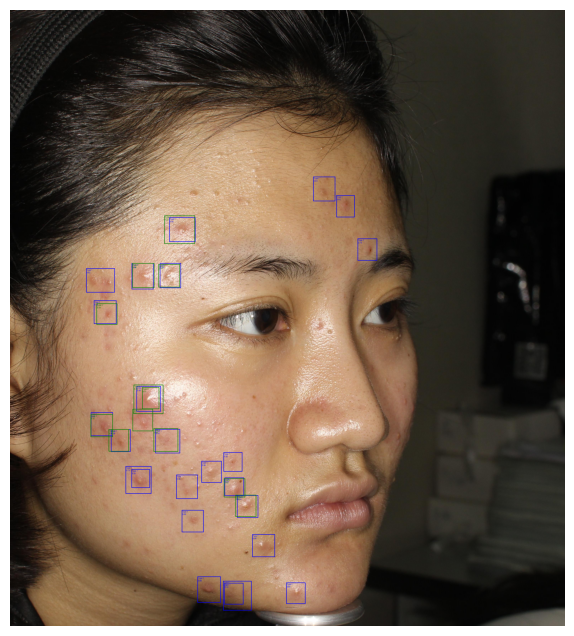


Detection Summary:
Total detections after NMS: 37
Type 1: confidence = 0.8830
Type 1: confidence = 0.8609
Type 1: confidence = 0.8503
Type 1: confidence = 0.8386
Type 1: confidence = 0.8218
Type 1: confidence = 0.8210
Type 1: confidence = 0.7615
Type 1: confidence = 0.7403
Type 1: confidence = 0.7261
Type 1: confidence = 0.6845
Type 1: confidence = 0.6329
Type 1: confidence = 0.5848
Type 1: confidence = 0.4905
Type 1: confidence = 0.4489
Type 1: confidence = 0.3910
Type 1: confidence = 0.3773
Type 1: confidence = 0.3769
Type 1: confidence = 0.3671
Type 1: confidence = 0.3555
Type 1: confidence = 0.3391
Type 1: confidence = 0.3340
Type 1: confidence = 0.3281
Type 1: confidence = 0.3244
Type 1: confidence = 0.3049
Type 1: confidence = 0.3019
Type 2: confidence = 0.5490
Type 2: confidence = 0.4795
Type 2: confidence = 0.4662
Type 2: confidence = 0.4473
Type 2: confidence = 0.4357
Type 2: confidence = 0.4351
Type 2: confidence = 0.4349
Type 2: confidence = 0.4196
Type 2: confidence = 0.33

In [105]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import nms
from PIL import Image

def run_inference(model, image_path, confidence_threshold=0.3, iou_threshold=0.3):
    """
    Run inference with NMS
    Args:
        model: Trained detection model
        image_path: Path to image
        confidence_threshold: Minimum confidence score to keep detection
        iou_threshold: IoU threshold for NMS
    """
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)
    
    # Run inference
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Get predictions for first image
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
    
    # Filter by confidence threshold
    mask = scores > confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    # Apply NMS for each class separately
    keep_boxes = []
    keep_scores = []
    keep_labels = []
    
    for class_id in torch.unique(labels):
        class_mask = labels == class_id
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]
        
        # Apply NMS
        keep_idx = nms(class_boxes, class_scores, iou_threshold)
        
        # Keep the selected boxes
        keep_boxes.append(class_boxes[keep_idx])
        keep_scores.append(class_scores[keep_idx])
        keep_labels.extend([class_id] * len(keep_idx))
    
    # Combine all kept detections
    if keep_boxes:
        boxes = torch.cat(keep_boxes)
        scores = torch.cat(keep_scores)
        labels = torch.tensor(keep_labels, device=device)
    else:
        boxes = torch.tensor([], device=device)
        scores = torch.tensor([], device=device)
        labels = torch.tensor([], device=device)
    
    # Prepare image for visualization
    image_tensor = image_tensor.squeeze(0).cpu()
    
    # Create color map for different classes
    colors = ["red", "blue", "green", "yellow"]
    box_colors = [colors[label.item() % len(colors)] for label in labels]
    
    # Create labels with confidence scores
    box_labels = [f"Type {label.item()}\n{score:.2f}" 
                 for label, score in zip(labels, scores)]
    
    # Draw boxes
    image_with_boxes = draw_bounding_boxes(
        (image_tensor * 255).to(torch.uint8),
        boxes,
        labels=box_labels,
        colors=box_colors,
        width=3,
        font_size=30
    )
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()
    
    # Print detection summary
    print("\nDetection Summary:")
    print(f"Total detections after NMS: {len(boxes)}")
    for label, score in zip(labels, scores):
        print(f"Type {label.item()}: confidence = {score.item():.4f}")
    
    return boxes, labels, scores

# Example usage
image_path = 'acne04-dataset/Classification/Classification/JPEGImages/levle2_121.jpg'
boxes, labels, scores = run_inference(
    model=model,
    image_path=image_path,
    confidence_threshold=0.3,
    iou_threshold=0.9
)

Test: Example 2

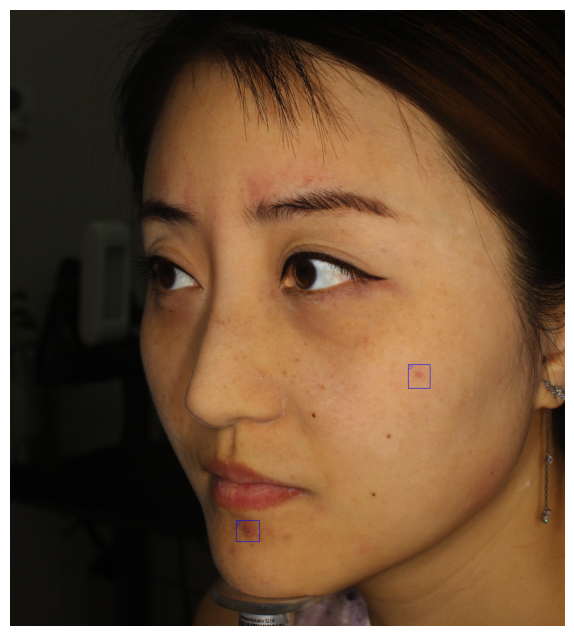


Detection Summary:
Total detections after NMS: 2
Type 1: confidence = 0.8467
Type 1: confidence = 0.3067


In [106]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import nms
from PIL import Image

def run_inference(model, image_path, confidence_threshold=0.3, iou_threshold=0.3):
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image).unsqueeze(0)
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_tensor = image_tensor.to(device)
    
    # Run inference
    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)
    
    # Get predictions for first image
    boxes = predictions[0]['boxes']
    scores = predictions[0]['scores']
    labels = predictions[0]['labels']
    
    # Filter by confidence threshold
    mask = scores > confidence_threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]
    
    # Apply NMS for each class separately
    keep_boxes = []
    keep_scores = []
    keep_labels = []
    
    for class_id in torch.unique(labels):
        class_mask = labels == class_id
        class_boxes = boxes[class_mask]
        class_scores = scores[class_mask]
        
        # Apply NMS
        keep_idx = nms(class_boxes, class_scores, iou_threshold)
        
        # Keep the selected boxes
        keep_boxes.append(class_boxes[keep_idx])
        keep_scores.append(class_scores[keep_idx])
        keep_labels.extend([class_id] * len(keep_idx))
    
    # Combine all kept detections
    if keep_boxes:
        boxes = torch.cat(keep_boxes)
        scores = torch.cat(keep_scores)
        labels = torch.tensor(keep_labels, device=device)
    else:
        boxes = torch.tensor([], device=device)
        scores = torch.tensor([], device=device)
        labels = torch.tensor([], device=device)
    
    # Prepare image for visualization
    image_tensor = image_tensor.squeeze(0).cpu()
    
    # Create color map for different classes
    colors = ["red", "blue", "green", "yellow"]
    box_colors = [colors[label.item() % len(colors)] for label in labels]
    
    # Create labels with confidence scores
    box_labels = [f"Type {label.item()}\n{score:.2f}" 
                 for label, score in zip(labels, scores)]
    
    # Draw boxes
    image_with_boxes = draw_bounding_boxes(
        (image_tensor * 255).to(torch.uint8),
        boxes,
        labels=box_labels,
        colors=box_colors,
        width=3,
        font_size=30
    )
    
    # Display results
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()
    
    # Print detection summary
    print("\nDetection Summary:")
    print(f"Total detections after NMS: {len(boxes)}")
    for label, score in zip(labels, scores):
        print(f"Type {label.item()}: confidence = {score.item():.4f}")
    
    return boxes, labels, scores

# Example usage
image_path = 'acne04-dataset/Classification/Classification/JPEGImages/levle0_105.jpg'
boxes, labels, scores = run_inference(
    model=model,
    image_path=image_path,
    confidence_threshold=0.3,
    iou_threshold=0.9
)

evaluating MAPE for selected 5 images

In [118]:
import numpy as np
import torch

def calculate_mape(predictions, targets):
    """Calculate MAPE (Mean Absolute Percentage Error)"""
    pred_boxes = predictions['boxes'].cpu().detach().numpy()
    target_boxes = targets['boxes'].cpu().detach().numpy()
    
    # Get the number of predicted and target boxes
    num_pred_boxes = pred_boxes.shape[0]
    num_target_boxes = target_boxes.shape[0]
    
    # If there are no predictions or no targets, return NaN (you could choose a different strategy)
    if num_pred_boxes == 0 or num_target_boxes == 0:
        return np.nan

    # Use the minimum number of boxes (either predicted or target) for comparison
    min_boxes = min(num_pred_boxes, num_target_boxes)

    # Calculate the area of the predicted and true bounding boxes
    pred_area = (pred_boxes[:min_boxes, 2] - pred_boxes[:min_boxes, 0]) * (pred_boxes[:min_boxes, 3] - pred_boxes[:min_boxes, 1])
    target_area = (target_boxes[:min_boxes, 2] - target_boxes[:min_boxes, 0]) * (target_boxes[:min_boxes, 3] - target_boxes[:min_boxes, 1])

    # Calculate MAPE for each bounding box
    mape = np.abs((pred_area - target_area) / target_area) * 100
    return np.mean(mape)

# Example: Evaluate the model on specific images from the dataset
model.eval()

# List of indices of images you want to evaluate
image_indices = [0, 5, 10, 15, 20]  # Example indices of images you want to evaluate

total_mape = 0
num_images = len(image_indices)

# Loop over the specific image indices
for i in tqdm(image_indices, desc="Evaluating", unit="image"):
    image, target = dataset[i]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        prediction = model(image)

    # Calculate MAPE for the current image
    mape = calculate_mape(prediction[0], target)
    total_mape += mape

    print(f"MAPE for image {i}: {mape:.2f}%")

# Calculate and print average MAPE for the selected images
avg_mape = total_mape / num_images
print(f"Average MAPE for selected images: {avg_mape:.2f}%")



Evaluating:  20%|██        | 1/5 [00:00<00:02,  1.86image/s]

MAPE for image 0: 36.06%


Evaluating:  40%|████      | 2/5 [00:00<00:01,  2.62image/s]

MAPE for image 5: 40.22%


Evaluating:  60%|██████    | 3/5 [00:01<00:00,  3.22image/s]

MAPE for image 10: 4.89%


Evaluating:  80%|████████  | 4/5 [00:01<00:00,  3.49image/s]

MAPE for image 15: 3.51%


Evaluating: 100%|██████████| 5/5 [00:01<00:00,  3.24image/s]

MAPE for image 20: 28.42%
Average MAPE for selected images: 22.62%


evaluating mape for all the images

In [49]:
import numpy as np
import torch
from tqdm import tqdm  # For progress bar

def calculate_mape(predictions, targets):
    """Calculate MAPE (Mean Absolute Percentage Error)"""
    pred_boxes = predictions['boxes'].cpu().detach().numpy()
    target_boxes = targets['boxes'].cpu().detach().numpy()
    
    # Get the number of predicted and target boxes
    num_pred_boxes = pred_boxes.shape[0]
    num_target_boxes = target_boxes.shape[0]
    
    # If there are no predictions or no targets, return NaN (you could choose a different strategy)
    if num_pred_boxes == 0 or num_target_boxes == 0:
        return np.nan

    # Use the minimum number of boxes (either predicted or target) for comparison
    min_boxes = min(num_pred_boxes, num_target_boxes)

    # Calculate the area of the predicted and true bounding boxes
    pred_area = (pred_boxes[:min_boxes, 2] - pred_boxes[:min_boxes, 0]) * (pred_boxes[:min_boxes, 3] - pred_boxes[:min_boxes, 1])
    target_area = (target_boxes[:min_boxes, 2] - target_boxes[:min_boxes, 0]) * (target_boxes[:min_boxes, 3] - target_boxes[:min_boxes, 1])

    # Calculate MAPE for each bounding box
    mape = np.abs((pred_area - target_area) / target_area) * 100
    return np.mean(mape)

# Example: Evaluate the model on all images from the dataset
model.eval()

total_mape = 0
num_images = len(dataset)  # Evaluate on all images in the dataset

# Loop over all images in the dataset with progress bar
for i in tqdm(range(num_images), desc="Evaluating", unit="image"):
    image, target = dataset[i]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

    with torch.no_grad():
        prediction = model(image)

    # Calculate MAPE for the current image
    mape = calculate_mape(prediction[0], target)
    
    # Skip if MAPE is NaN (when there are no predictions or targets)
    if not np.isnan(mape):
        total_mape += mape
        print(f"MAPE for image {i}: {mape:.2f}%")
    else:
        print(f"Skipping image {i} due to no predictions or no ground truth.")

# Calculate and print average MAPE for all images
avg_mape = total_mape / num_images
print(f"Average MAPE for all images: {avg_mape:.2f}%")


Evaluating:   0%|          | 1/1457 [00:00<02:32,  9.55image/s]

MAPE for image 0: 36.06%


Evaluating:   0%|          | 3/1457 [00:00<04:17,  5.66image/s]

MAPE for image 1: 19.19%
MAPE for image 2: 18.90%


Evaluating:   0%|          | 4/1457 [00:00<04:27,  5.44image/s]

MAPE for image 3: 62.01%
MAPE for image 4: 20.07%


Evaluating:   0%|          | 6/1457 [00:01<04:45,  5.08image/s]

MAPE for image 5: 40.22%


Evaluating:   0%|          | 7/1457 [00:01<05:05,  4.75image/s]

MAPE for image 6: 49.36%


Evaluating:   1%|          | 8/1457 [00:01<05:18,  4.55image/s]

MAPE for image 7: 25.69%
MAPE for image 8: 4.62%


Evaluating:   1%|          | 10/1457 [00:01<05:03,  4.76image/s]

MAPE for image 9: 43.49%


Evaluating:   1%|          | 11/1457 [00:02<05:07,  4.71image/s]

MAPE for image 10: 4.89%


Evaluating:   1%|          | 12/1457 [00:02<05:07,  4.71image/s]

MAPE for image 11: 30.12%
MAPE for image 12: 22.31%


Evaluating:   1%|          | 14/1457 [00:02<05:11,  4.63image/s]

MAPE for image 13: 35.13%


Evaluating:   1%|          | 15/1457 [00:03<05:16,  4.55image/s]

MAPE for image 14: 159.07%


Evaluating:   1%|          | 16/1457 [00:03<05:14,  4.59image/s]

MAPE for image 15: 3.51%


Evaluating:   1%|          | 17/1457 [00:03<05:11,  4.63image/s]

MAPE for image 16: 13.52%


Evaluating:   1%|          | 18/1457 [00:03<05:24,  4.44image/s]

MAPE for image 17: 28.76%
MAPE for image 18: 590.20%


Evaluating:   1%|▏         | 20/1457 [00:04<04:30,  5.31image/s]

MAPE for image 19: 45.06%


Evaluating:   1%|▏         | 21/1457 [00:04<04:47,  5.00image/s]

MAPE for image 20: 28.42%
MAPE for image 21: 31.73%


Evaluating:   2%|▏         | 23/1457 [00:04<04:46,  5.00image/s]

MAPE for image 22: 37.21%
MAPE for image 23: 23.63%


Evaluating:   2%|▏         | 25/1457 [00:05<04:52,  4.89image/s]

MAPE for image 24: 37.88%


Evaluating:   2%|▏         | 26/1457 [00:05<05:02,  4.74image/s]

MAPE for image 25: 26.13%


Evaluating:   2%|▏         | 27/1457 [00:05<05:08,  4.64image/s]

MAPE for image 26: 0.87%
MAPE for image 27: 20.24%


Evaluating:   2%|▏         | 29/1457 [00:05<04:58,  4.78image/s]

MAPE for image 28: 16.83%


Evaluating:   2%|▏         | 30/1457 [00:06<05:04,  4.69image/s]

MAPE for image 29: 14.49%
MAPE for image 30: 35.62%


Evaluating:   2%|▏         | 32/1457 [00:06<05:14,  4.54image/s]

MAPE for image 31: 19.22%


Evaluating:   2%|▏         | 33/1457 [00:06<05:34,  4.26image/s]

MAPE for image 32: 32.09%
MAPE for image 33: 21.89%


Evaluating:   2%|▏         | 35/1457 [00:07<05:20,  4.44image/s]

Skipping image 34 due to no predictions or no ground truth.


Evaluating:   2%|▏         | 36/1457 [00:07<05:26,  4.36image/s]

MAPE for image 35: 13.53%


Evaluating:   3%|▎         | 37/1457 [00:07<05:28,  4.32image/s]

MAPE for image 36: 39.74%


Evaluating:   3%|▎         | 38/1457 [00:08<05:38,  4.19image/s]

MAPE for image 37: 22.02%


Evaluating:   3%|▎         | 39/1457 [00:08<06:03,  3.90image/s]

MAPE for image 38: 27.00%


Evaluating:   3%|▎         | 41/1457 [00:08<05:28,  4.32image/s]

MAPE for image 39: 9.45%
MAPE for image 40: 36.63%


Evaluating:   3%|▎         | 42/1457 [00:09<05:32,  4.25image/s]

MAPE for image 41: 43.04%


Evaluating:   3%|▎         | 43/1457 [00:09<05:40,  4.16image/s]

MAPE for image 42: 63.30%


Evaluating:   3%|▎         | 44/1457 [00:09<05:44,  4.11image/s]

MAPE for image 43: 35.10%


Evaluating:   3%|▎         | 45/1457 [00:09<05:44,  4.10image/s]

MAPE for image 44: 21.58%


Evaluating:   3%|▎         | 46/1457 [00:10<05:47,  4.06image/s]

MAPE for image 45: 20.74%


Evaluating:   3%|▎         | 47/1457 [00:10<05:44,  4.09image/s]

MAPE for image 46: 16.54%


Evaluating:   3%|▎         | 49/1457 [00:10<05:25,  4.33image/s]

Skipping image 47 due to no predictions or no ground truth.
Skipping image 48 due to no predictions or no ground truth.


Evaluating:   3%|▎         | 50/1457 [00:10<05:37,  4.17image/s]

MAPE for image 49: 42.55%


Evaluating:   4%|▎         | 51/1457 [00:11<05:34,  4.20image/s]

MAPE for image 50: 50.54%
MAPE for image 51: 34.70%


Evaluating:   4%|▎         | 53/1457 [00:11<05:23,  4.35image/s]

MAPE for image 52: 29.60%


Evaluating:   4%|▎         | 54/1457 [00:11<05:36,  4.17image/s]

MAPE for image 53: 33.94%
MAPE for image 54: 25.72%


Evaluating:   4%|▍         | 56/1457 [00:12<05:26,  4.29image/s]

MAPE for image 55: 14.92%


Evaluating:   4%|▍         | 57/1457 [00:12<05:26,  4.28image/s]

MAPE for image 56: 22.99%


Evaluating:   4%|▍         | 58/1457 [00:12<05:15,  4.43image/s]

MAPE for image 57: 2.66%


Evaluating:   4%|▍         | 60/1457 [00:13<04:28,  5.20image/s]

MAPE for image 58: 21.40%
MAPE for image 59: 44.89%


Evaluating:   4%|▍         | 61/1457 [00:13<04:32,  5.12image/s]

MAPE for image 60: 45.37%
MAPE for image 61: 7.79%


Evaluating:   4%|▍         | 63/1457 [00:13<04:32,  5.12image/s]

MAPE for image 62: 34.28%


Evaluating:   4%|▍         | 64/1457 [00:13<04:35,  5.05image/s]

MAPE for image 63: 17.34%


Evaluating:   4%|▍         | 65/1457 [00:14<04:46,  4.85image/s]

MAPE for image 64: 32.17%


Evaluating:   5%|▍         | 66/1457 [00:14<04:54,  4.72image/s]

MAPE for image 65: 41.82%


Evaluating:   5%|▍         | 68/1457 [00:14<04:52,  4.74image/s]

MAPE for image 66: 41.92%
MAPE for image 67: 11.76%


Evaluating:   5%|▍         | 69/1457 [00:15<05:08,  4.50image/s]

MAPE for image 68: 11.77%


Evaluating:   5%|▍         | 70/1457 [00:15<05:14,  4.41image/s]

MAPE for image 69: 1.81%


Evaluating:   5%|▍         | 71/1457 [00:15<05:33,  4.15image/s]

MAPE for image 70: 30.71%
MAPE for image 71: 23.58%


Evaluating:   5%|▌         | 73/1457 [00:15<05:07,  4.50image/s]

MAPE for image 72: 20.79%


Evaluating:   5%|▌         | 74/1457 [00:16<05:17,  4.35image/s]

MAPE for image 73: 48.53%


Evaluating:   5%|▌         | 75/1457 [00:16<05:18,  4.34image/s]

MAPE for image 74: 64.96%
MAPE for image 75: 38.00%


Evaluating:   5%|▌         | 77/1457 [00:16<05:21,  4.30image/s]

MAPE for image 76: 42.20%


Evaluating:   5%|▌         | 78/1457 [00:17<05:23,  4.26image/s]

MAPE for image 77: 49.72%
MAPE for image 78: 38.80%


Evaluating:   5%|▌         | 80/1457 [00:17<04:49,  4.76image/s]

MAPE for image 79: 35.96%
MAPE for image 80: 25.64%


Evaluating:   6%|▌         | 82/1457 [00:17<04:46,  4.79image/s]

MAPE for image 81: 55.05%


Evaluating:   6%|▌         | 83/1457 [00:18<04:53,  4.68image/s]

MAPE for image 82: 63.71%


Evaluating:   6%|▌         | 84/1457 [00:18<05:07,  4.47image/s]

MAPE for image 83: 49.15%


Evaluating:   6%|▌         | 85/1457 [00:18<05:00,  4.57image/s]

MAPE for image 84: 45.76%


Evaluating:   6%|▌         | 86/1457 [00:18<05:03,  4.52image/s]

MAPE for image 85: 37.28%
MAPE for image 86: 27.84%


Evaluating:   6%|▌         | 88/1457 [00:19<04:28,  5.11image/s]

MAPE for image 87: 21.93%
MAPE for image 88: 52.17%


Evaluating:   6%|▌         | 90/1457 [00:19<04:33,  5.00image/s]

MAPE for image 89: 38.09%
MAPE for image 90: 41.71%


Evaluating:   6%|▋         | 92/1457 [00:19<04:39,  4.88image/s]

MAPE for image 91: 42.01%


Evaluating:   6%|▋         | 93/1457 [00:20<04:49,  4.72image/s]

MAPE for image 92: 47.57%


Evaluating:   7%|▋         | 95/1457 [00:20<04:43,  4.81image/s]

MAPE for image 93: 15.54%
Skipping image 94 due to no predictions or no ground truth.


Evaluating:   7%|▋         | 96/1457 [00:20<04:39,  4.86image/s]

MAPE for image 95: 25.48%


Evaluating:   7%|▋         | 97/1457 [00:21<05:00,  4.52image/s]

MAPE for image 96: 30.06%


Evaluating:   7%|▋         | 99/1457 [00:21<04:52,  4.65image/s]

MAPE for image 97: 20.38%
MAPE for image 98: 42.21%


Evaluating:   7%|▋         | 101/1457 [00:21<04:55,  4.59image/s]

MAPE for image 99: 48.07%
MAPE for image 100: 46.95%


Evaluating:   7%|▋         | 102/1457 [00:22<05:04,  4.44image/s]

MAPE for image 101: 33.49%


Evaluating:   7%|▋         | 103/1457 [00:22<05:17,  4.26image/s]

MAPE for image 102: 51.60%
MAPE for image 103: 44.92%


Evaluating:   7%|▋         | 105/1457 [00:22<05:11,  4.35image/s]

MAPE for image 104: 136.55%


Evaluating:   7%|▋         | 107/1457 [00:23<05:38,  3.99image/s]

MAPE for image 105: 39.65%
MAPE for image 106: 35.93%


Evaluating:   7%|▋         | 108/1457 [00:23<05:21,  4.19image/s]

MAPE for image 107: 17.39%
MAPE for image 108: 19.99%


Evaluating:   8%|▊         | 110/1457 [00:24<04:59,  4.50image/s]

MAPE for image 109: 38.95%


Evaluating:   8%|▊         | 111/1457 [00:24<05:00,  4.47image/s]

MAPE for image 110: 16.53%
MAPE for image 111: 39.40%


Evaluating:   8%|▊         | 113/1457 [00:24<04:41,  4.78image/s]

MAPE for image 112: 7.63%
MAPE for image 113: 102.15%


Evaluating:   8%|▊         | 115/1457 [00:25<04:41,  4.76image/s]

MAPE for image 114: 35.49%


Evaluating:   8%|▊         | 116/1457 [00:25<04:44,  4.72image/s]

MAPE for image 115: 16.27%


Evaluating:   8%|▊         | 117/1457 [00:25<04:47,  4.66image/s]

MAPE for image 116: 38.42%


Evaluating:   8%|▊         | 118/1457 [00:25<04:46,  4.68image/s]

MAPE for image 117: 50.99%


Evaluating:   8%|▊         | 119/1457 [00:25<04:49,  4.63image/s]

MAPE for image 118: 165.76%


Evaluating:   8%|▊         | 120/1457 [00:26<04:50,  4.61image/s]

MAPE for image 119: 30.19%


Evaluating:   8%|▊         | 121/1457 [00:26<05:02,  4.41image/s]

MAPE for image 120: 49.00%


Evaluating:   8%|▊         | 122/1457 [00:26<05:11,  4.29image/s]

MAPE for image 121: 37.34%
MAPE for image 122: 35.22%


Evaluating:   9%|▊         | 124/1457 [00:27<04:49,  4.61image/s]

MAPE for image 123: 48.16%


Evaluating:   9%|▊         | 125/1457 [00:27<04:50,  4.59image/s]

MAPE for image 124: 53.23%


Evaluating:   9%|▊         | 126/1457 [00:27<05:00,  4.43image/s]

MAPE for image 125: 41.48%


Evaluating:   9%|▊         | 127/1457 [00:27<04:55,  4.49image/s]

MAPE for image 126: 62.45%


Evaluating:   9%|▉         | 128/1457 [00:28<04:58,  4.46image/s]

MAPE for image 127: 54.82%
MAPE for image 128: 55.35%


Evaluating:   9%|▉         | 130/1457 [00:28<04:41,  4.72image/s]

MAPE for image 129: 38.40%


Evaluating:   9%|▉         | 131/1457 [00:28<04:50,  4.57image/s]

MAPE for image 130: 30.54%


Evaluating:   9%|▉         | 132/1457 [00:28<04:59,  4.43image/s]

MAPE for image 131: 67.53%


Evaluating:   9%|▉         | 133/1457 [00:29<05:14,  4.21image/s]

MAPE for image 132: 39.83%


Evaluating:   9%|▉         | 134/1457 [00:29<05:12,  4.23image/s]

Skipping image 133 due to no predictions or no ground truth.


Evaluating:   9%|▉         | 135/1457 [00:29<05:11,  4.25image/s]

MAPE for image 134: 41.19%


Evaluating:   9%|▉         | 136/1457 [00:29<05:12,  4.23image/s]

MAPE for image 135: 41.95%


Evaluating:   9%|▉         | 137/1457 [00:30<05:12,  4.22image/s]

MAPE for image 136: 16.30%


Evaluating:   9%|▉         | 138/1457 [00:30<05:07,  4.29image/s]

MAPE for image 137: 35.23%


Evaluating:  10%|▉         | 139/1457 [00:30<05:00,  4.39image/s]

MAPE for image 138: 62.65%


Evaluating:  10%|▉         | 140/1457 [00:30<04:53,  4.49image/s]

MAPE for image 139: 38.65%


Evaluating:  10%|▉         | 141/1457 [00:30<04:51,  4.51image/s]

MAPE for image 140: 41.04%


Evaluating:  10%|▉         | 142/1457 [00:31<04:54,  4.46image/s]

MAPE for image 141: 47.29%


Evaluating:  10%|▉         | 143/1457 [00:31<05:03,  4.33image/s]

MAPE for image 142: 28.66%


Evaluating:  10%|▉         | 144/1457 [00:31<05:19,  4.11image/s]

MAPE for image 143: 79.32%


Evaluating:  10%|█         | 146/1457 [00:32<04:56,  4.42image/s]

MAPE for image 144: 26.91%
MAPE for image 145: 42.47%


Evaluating:  10%|█         | 147/1457 [00:32<04:56,  4.42image/s]

MAPE for image 146: 24.39%


Evaluating:  10%|█         | 148/1457 [00:32<04:54,  4.45image/s]

MAPE for image 147: 13.74%


Evaluating:  10%|█         | 149/1457 [00:32<04:55,  4.43image/s]

MAPE for image 148: 45.69%


Evaluating:  10%|█         | 150/1457 [00:33<04:49,  4.52image/s]

MAPE for image 149: 6.04%


Evaluating:  10%|█         | 151/1457 [00:33<04:51,  4.47image/s]

MAPE for image 150: 16.78%


Evaluating:  10%|█         | 152/1457 [00:33<05:22,  4.04image/s]

MAPE for image 151: 15.05%


Evaluating:  11%|█         | 153/1457 [00:33<05:12,  4.17image/s]

MAPE for image 152: 35.06%


Evaluating:  11%|█         | 154/1457 [00:34<05:13,  4.16image/s]

MAPE for image 153: 41.92%


Evaluating:  11%|█         | 155/1457 [00:34<05:01,  4.32image/s]

MAPE for image 154: 42.04%


Evaluating:  11%|█         | 156/1457 [00:34<05:05,  4.26image/s]

MAPE for image 155: 41.85%


Evaluating:  11%|█         | 157/1457 [00:34<04:55,  4.40image/s]

MAPE for image 156: 57.69%


Evaluating:  11%|█         | 158/1457 [00:34<04:50,  4.48image/s]

MAPE for image 157: 39.88%


Evaluating:  11%|█         | 159/1457 [00:35<04:58,  4.35image/s]

Skipping image 158 due to no predictions or no ground truth.


Evaluating:  11%|█         | 160/1457 [00:35<05:12,  4.16image/s]

MAPE for image 159: 44.09%


Evaluating:  11%|█         | 161/1457 [00:35<05:01,  4.30image/s]

MAPE for image 160: 36.81%


Evaluating:  11%|█         | 162/1457 [00:35<04:53,  4.41image/s]

MAPE for image 161: 53.59%


Evaluating:  11%|█▏        | 164/1457 [00:36<04:43,  4.56image/s]

MAPE for image 162: 57.00%
MAPE for image 163: 38.98%


Evaluating:  11%|█▏        | 165/1457 [00:36<04:42,  4.57image/s]

MAPE for image 164: 49.18%


Evaluating:  11%|█▏        | 166/1457 [00:36<04:42,  4.58image/s]

MAPE for image 165: 1.89%


Evaluating:  11%|█▏        | 167/1457 [00:36<04:56,  4.35image/s]

MAPE for image 166: 60.03%


Evaluating:  12%|█▏        | 168/1457 [00:37<04:56,  4.35image/s]

Skipping image 167 due to no predictions or no ground truth.


Evaluating:  12%|█▏        | 169/1457 [00:37<04:59,  4.30image/s]

MAPE for image 168: 18.20%


Evaluating:  12%|█▏        | 170/1457 [00:37<05:06,  4.20image/s]

MAPE for image 169: 42.10%


Evaluating:  12%|█▏        | 171/1457 [00:37<05:11,  4.12image/s]

MAPE for image 170: 14.02%


Evaluating:  12%|█▏        | 172/1457 [00:38<05:10,  4.14image/s]

MAPE for image 171: 21.23%
MAPE for image 172: 38.03%


Evaluating:  12%|█▏        | 175/1457 [00:38<04:38,  4.60image/s]

MAPE for image 173: 27.77%
MAPE for image 174: 34.32%


Evaluating:  12%|█▏        | 176/1457 [00:39<04:41,  4.56image/s]

MAPE for image 175: 43.50%


Evaluating:  12%|█▏        | 177/1457 [00:39<04:42,  4.53image/s]

MAPE for image 176: 31.50%


Evaluating:  12%|█▏        | 178/1457 [00:39<04:40,  4.56image/s]

Skipping image 177 due to no predictions or no ground truth.


Evaluating:  12%|█▏        | 179/1457 [00:39<04:40,  4.55image/s]

MAPE for image 178: 31.62%


Evaluating:  12%|█▏        | 180/1457 [00:39<04:46,  4.46image/s]

MAPE for image 179: 15.14%


Evaluating:  12%|█▏        | 181/1457 [00:40<04:42,  4.52image/s]

MAPE for image 180: 20.77%


Evaluating:  12%|█▏        | 182/1457 [00:40<04:42,  4.52image/s]

MAPE for image 181: 26.14%
MAPE for image 182: 17.58%


Evaluating:  13%|█▎        | 184/1457 [00:40<04:39,  4.56image/s]

MAPE for image 183: 39.06%


Evaluating:  13%|█▎        | 185/1457 [00:40<04:41,  4.52image/s]

MAPE for image 184: 41.71%


Evaluating:  13%|█▎        | 186/1457 [00:41<05:03,  4.19image/s]

MAPE for image 185: 14.79%


Evaluating:  13%|█▎        | 187/1457 [00:41<05:01,  4.21image/s]

MAPE for image 186: 55.40%


Evaluating:  13%|█▎        | 188/1457 [00:41<04:54,  4.31image/s]

MAPE for image 187: 23.48%


Evaluating:  13%|█▎        | 190/1457 [00:42<04:53,  4.32image/s]

MAPE for image 188: 60.21%
MAPE for image 189: 41.30%


Evaluating:  13%|█▎        | 191/1457 [00:42<04:43,  4.46image/s]

MAPE for image 190: 34.98%
MAPE for image 191: 4.04%


Evaluating:  13%|█▎        | 194/1457 [00:43<04:34,  4.61image/s]

MAPE for image 192: 22.24%
MAPE for image 193: 51.66%


Evaluating:  13%|█▎        | 196/1457 [00:43<04:37,  4.54image/s]

MAPE for image 194: 27.21%
MAPE for image 195: 7.85%


Evaluating:  14%|█▎        | 197/1457 [00:43<04:43,  4.45image/s]

Skipping image 196 due to no predictions or no ground truth.


Evaluating:  14%|█▎        | 198/1457 [00:43<04:40,  4.48image/s]

MAPE for image 197: 0.01%


Evaluating:  14%|█▎        | 199/1457 [00:44<04:41,  4.46image/s]

MAPE for image 198: 27.83%


Evaluating:  14%|█▎        | 200/1457 [00:44<04:45,  4.40image/s]

MAPE for image 199: 16.64%


Evaluating:  14%|█▍        | 201/1457 [00:44<05:07,  4.09image/s]

MAPE for image 200: 4.21%


Evaluating:  14%|█▍        | 202/1457 [00:44<05:07,  4.08image/s]

MAPE for image 201: 27.37%


Evaluating:  14%|█▍        | 203/1457 [00:45<05:10,  4.04image/s]

MAPE for image 202: 65.39%


Evaluating:  14%|█▍        | 204/1457 [00:45<05:03,  4.13image/s]

MAPE for image 203: 28.82%


Evaluating:  14%|█▍        | 205/1457 [00:45<04:57,  4.21image/s]

MAPE for image 204: 28.71%


Evaluating:  14%|█▍        | 206/1457 [00:45<05:00,  4.17image/s]

MAPE for image 205: 18.52%


Evaluating:  14%|█▍        | 207/1457 [00:46<05:18,  3.93image/s]

MAPE for image 206: 39.51%


Evaluating:  14%|█▍        | 208/1457 [00:46<05:09,  4.03image/s]

MAPE for image 207: 37.88%


Evaluating:  14%|█▍        | 209/1457 [00:46<04:57,  4.19image/s]

MAPE for image 208: 16.98%


Evaluating:  14%|█▍        | 210/1457 [00:46<04:49,  4.31image/s]

MAPE for image 209: 27.47%


Evaluating:  14%|█▍        | 211/1457 [00:47<05:02,  4.12image/s]

MAPE for image 210: 12.32%


Evaluating:  15%|█▍        | 212/1457 [00:47<05:09,  4.02image/s]

MAPE for image 211: 19.65%


Evaluating:  15%|█▍        | 213/1457 [00:47<05:06,  4.06image/s]

MAPE for image 212: 49.28%


Evaluating:  15%|█▍        | 214/1457 [00:47<04:55,  4.20image/s]

MAPE for image 213: 54.10%


Evaluating:  15%|█▍        | 215/1457 [00:48<04:58,  4.16image/s]

MAPE for image 214: 4.86%


Evaluating:  15%|█▍        | 216/1457 [00:48<05:07,  4.04image/s]

MAPE for image 215: 32.26%


Evaluating:  15%|█▍        | 217/1457 [00:48<05:05,  4.06image/s]

MAPE for image 216: 17.85%


Evaluating:  15%|█▍        | 218/1457 [00:48<04:53,  4.23image/s]

MAPE for image 217: 27.70%


Evaluating:  15%|█▌        | 219/1457 [00:49<04:51,  4.24image/s]

MAPE for image 218: 50.57%


Evaluating:  15%|█▌        | 220/1457 [00:49<04:51,  4.24image/s]

MAPE for image 219: 23.06%


Evaluating:  15%|█▌        | 221/1457 [00:49<04:50,  4.26image/s]

MAPE for image 220: 4.51%


Evaluating:  15%|█▌        | 223/1457 [00:49<04:03,  5.06image/s]

MAPE for image 221: 27.05%
MAPE for image 222: 20.93%


Evaluating:  15%|█▌        | 224/1457 [00:50<04:12,  4.88image/s]

MAPE for image 223: 21.24%
MAPE for image 224: 75.52%


Evaluating:  16%|█▌        | 226/1457 [00:50<04:14,  4.84image/s]

MAPE for image 225: 23.80%
Skipping image 226 due to no predictions or no ground truth.


Evaluating:  16%|█▌        | 228/1457 [00:50<04:08,  4.95image/s]

MAPE for image 227: 71.48%


Evaluating:  16%|█▌        | 229/1457 [00:51<04:19,  4.73image/s]

MAPE for image 228: 25.21%


Evaluating:  16%|█▌        | 230/1457 [00:51<04:32,  4.50image/s]

Skipping image 229 due to no predictions or no ground truth.


Evaluating:  16%|█▌        | 231/1457 [00:51<04:37,  4.41image/s]

MAPE for image 230: 23.29%


Evaluating:  16%|█▌        | 232/1457 [00:51<04:34,  4.47image/s]

MAPE for image 231: 44.87%


Evaluating:  16%|█▌        | 233/1457 [00:52<04:32,  4.49image/s]

MAPE for image 232: 25.82%
MAPE for image 233: 36.41%


Evaluating:  16%|█▌        | 235/1457 [00:52<04:20,  4.68image/s]

MAPE for image 234: 33.32%


Evaluating:  16%|█▌        | 236/1457 [00:52<04:24,  4.62image/s]

MAPE for image 235: 20.61%


Evaluating:  16%|█▋        | 237/1457 [00:52<04:27,  4.56image/s]

MAPE for image 236: 26.74%


Evaluating:  16%|█▋        | 238/1457 [00:53<04:38,  4.37image/s]

MAPE for image 237: 31.65%


Evaluating:  16%|█▋        | 239/1457 [00:53<04:39,  4.36image/s]

MAPE for image 238: 35.45%


Evaluating:  16%|█▋        | 240/1457 [00:53<04:42,  4.31image/s]

MAPE for image 239: 38.46%


Evaluating:  17%|█▋        | 241/1457 [00:53<04:46,  4.24image/s]

MAPE for image 240: 51.21%


Evaluating:  17%|█▋        | 242/1457 [00:54<04:38,  4.37image/s]

MAPE for image 241: 28.07%


Evaluating:  17%|█▋        | 244/1457 [00:54<04:28,  4.51image/s]

MAPE for image 242: 21.13%
MAPE for image 243: 29.09%


Evaluating:  17%|█▋        | 245/1457 [00:54<04:29,  4.49image/s]

MAPE for image 244: 58.19%


Evaluating:  17%|█▋        | 246/1457 [00:54<04:24,  4.58image/s]

MAPE for image 245: 70.19%


Evaluating:  17%|█▋        | 247/1457 [00:55<04:23,  4.60image/s]

MAPE for image 246: 26.04%


Evaluating:  17%|█▋        | 248/1457 [00:55<04:38,  4.33image/s]

MAPE for image 247: 8.49%


Evaluating:  17%|█▋        | 249/1457 [00:55<04:39,  4.33image/s]

MAPE for image 248: 34.98%


Evaluating:  17%|█▋        | 250/1457 [00:55<04:38,  4.33image/s]

MAPE for image 249: 31.55%


Evaluating:  17%|█▋        | 252/1457 [00:56<04:01,  4.99image/s]

MAPE for image 250: 27.10%
MAPE for image 251: 62.15%


Evaluating:  17%|█▋        | 253/1457 [00:56<04:08,  4.84image/s]

MAPE for image 252: 44.59%
MAPE for image 253: 27.72%


Evaluating:  18%|█▊        | 255/1457 [00:56<04:27,  4.50image/s]

MAPE for image 254: 55.70%


Evaluating:  18%|█▊        | 256/1457 [00:57<04:45,  4.21image/s]

MAPE for image 255: 25.61%
MAPE for image 256: 7.28%


Evaluating:  18%|█▊        | 258/1457 [00:57<04:30,  4.43image/s]

MAPE for image 257: 49.59%


Evaluating:  18%|█▊        | 259/1457 [00:57<04:31,  4.41image/s]

MAPE for image 258: 14.35%


Evaluating:  18%|█▊        | 260/1457 [00:58<04:25,  4.51image/s]

MAPE for image 259: 52.87%
MAPE for image 260: 66.03%


Evaluating:  18%|█▊        | 262/1457 [00:58<04:14,  4.69image/s]

MAPE for image 261: 0.68%
MAPE for image 262: 42.93%


Evaluating:  18%|█▊        | 264/1457 [00:58<04:13,  4.71image/s]

MAPE for image 263: 36.73%


Evaluating:  18%|█▊        | 265/1457 [00:59<04:10,  4.76image/s]

MAPE for image 264: 6.36%
MAPE for image 265: 15.15%


Evaluating:  18%|█▊        | 267/1457 [00:59<04:12,  4.72image/s]

MAPE for image 266: 35.41%


Evaluating:  18%|█▊        | 268/1457 [00:59<04:18,  4.59image/s]

MAPE for image 267: 40.95%


Evaluating:  18%|█▊        | 269/1457 [01:00<04:24,  4.50image/s]

MAPE for image 268: 11.36%


Evaluating:  19%|█▊        | 270/1457 [01:00<04:22,  4.52image/s]

MAPE for image 269: 36.10%


Evaluating:  19%|█▊        | 271/1457 [01:00<04:21,  4.53image/s]

MAPE for image 270: 33.90%


Evaluating:  19%|█▊        | 272/1457 [01:00<04:23,  4.49image/s]

Skipping image 271 due to no predictions or no ground truth.


Evaluating:  19%|█▊        | 273/1457 [01:00<04:16,  4.61image/s]

MAPE for image 272: 0.66%


Evaluating:  19%|█▉        | 274/1457 [01:01<04:24,  4.47image/s]

MAPE for image 273: 33.86%


Evaluating:  19%|█▉        | 275/1457 [01:01<04:24,  4.47image/s]

MAPE for image 274: 13.21%


Evaluating:  19%|█▉        | 276/1457 [01:01<04:27,  4.42image/s]

MAPE for image 275: 17.04%


Evaluating:  19%|█▉        | 277/1457 [01:01<04:21,  4.51image/s]

MAPE for image 276: 44.52%


Evaluating:  19%|█▉        | 278/1457 [01:02<04:25,  4.44image/s]

MAPE for image 277: 34.03%


Evaluating:  19%|█▉        | 279/1457 [01:02<04:31,  4.34image/s]

MAPE for image 278: 34.79%


Evaluating:  19%|█▉        | 280/1457 [01:02<04:29,  4.37image/s]

MAPE for image 279: 68.14%


Evaluating:  19%|█▉        | 281/1457 [01:02<04:39,  4.21image/s]

MAPE for image 280: 46.19%


Evaluating:  19%|█▉        | 282/1457 [01:02<04:33,  4.29image/s]

MAPE for image 281: 45.86%


Evaluating:  19%|█▉        | 283/1457 [01:03<04:28,  4.37image/s]

MAPE for image 282: 18.72%


Evaluating:  19%|█▉        | 284/1457 [01:03<04:32,  4.30image/s]

MAPE for image 283: 2.97%


Evaluating:  20%|█▉        | 285/1457 [01:03<04:30,  4.33image/s]

MAPE for image 284: 48.65%


Evaluating:  20%|█▉        | 286/1457 [01:03<04:27,  4.37image/s]

MAPE for image 285: 41.99%
MAPE for image 286: 10.67%


Evaluating:  20%|█▉        | 288/1457 [01:04<04:20,  4.49image/s]

MAPE for image 287: 53.78%


Evaluating:  20%|█▉        | 289/1457 [01:04<04:27,  4.36image/s]

MAPE for image 288: 49.61%


Evaluating:  20%|█▉        | 290/1457 [01:04<04:25,  4.40image/s]

MAPE for image 289: 52.51%


Evaluating:  20%|█▉        | 291/1457 [01:05<04:31,  4.29image/s]

MAPE for image 290: 60.84%


Evaluating:  20%|██        | 292/1457 [01:05<04:28,  4.35image/s]

MAPE for image 291: 49.47%


Evaluating:  20%|██        | 293/1457 [01:05<04:24,  4.40image/s]

MAPE for image 292: 20.70%


Evaluating:  20%|██        | 294/1457 [01:05<04:28,  4.34image/s]

MAPE for image 293: 170.51%


Evaluating:  20%|██        | 296/1457 [01:06<04:14,  4.57image/s]

MAPE for image 294: 34.34%
MAPE for image 295: 39.56%


Evaluating:  20%|██        | 297/1457 [01:06<04:26,  4.36image/s]

MAPE for image 296: 22.87%


Evaluating:  20%|██        | 298/1457 [01:06<04:38,  4.16image/s]

MAPE for image 297: 61.99%


Evaluating:  21%|██        | 299/1457 [01:06<04:29,  4.30image/s]

MAPE for image 298: 37.63%


Evaluating:  21%|██        | 300/1457 [01:07<04:23,  4.38image/s]

MAPE for image 299: 36.89%


Evaluating:  21%|██        | 301/1457 [01:07<04:22,  4.40image/s]

MAPE for image 300: 30.80%


Evaluating:  21%|██        | 302/1457 [01:07<04:32,  4.23image/s]

MAPE for image 301: 70.17%


Evaluating:  21%|██        | 303/1457 [01:07<04:36,  4.17image/s]

MAPE for image 302: 32.17%


Evaluating:  21%|██        | 304/1457 [01:08<04:47,  4.01image/s]

MAPE for image 303: 32.23%


Evaluating:  21%|██        | 305/1457 [01:08<04:44,  4.04image/s]

MAPE for image 304: 23.67%


Evaluating:  21%|██        | 306/1457 [01:08<04:41,  4.10image/s]

MAPE for image 305: 37.04%


Evaluating:  21%|██        | 307/1457 [01:08<04:33,  4.20image/s]

MAPE for image 306: 25.64%


Evaluating:  21%|██        | 308/1457 [01:09<04:41,  4.08image/s]

MAPE for image 307: 53.75%


Evaluating:  21%|██        | 309/1457 [01:09<04:34,  4.18image/s]

MAPE for image 308: 48.04%


Evaluating:  21%|██▏       | 310/1457 [01:09<04:34,  4.17image/s]

MAPE for image 309: 70.99%


Evaluating:  21%|██▏       | 311/1457 [01:09<04:29,  4.25image/s]

MAPE for image 310: 30.26%


Evaluating:  21%|██▏       | 312/1457 [01:09<04:35,  4.16image/s]

MAPE for image 311: 64.72%


Evaluating:  21%|██▏       | 313/1457 [01:10<04:39,  4.10image/s]

MAPE for image 312: 27.48%


Evaluating:  22%|██▏       | 314/1457 [01:10<04:39,  4.09image/s]

MAPE for image 313: 17.68%


Evaluating:  22%|██▏       | 315/1457 [01:10<04:35,  4.15image/s]

MAPE for image 314: 68.52%


Evaluating:  22%|██▏       | 316/1457 [01:10<04:35,  4.13image/s]

MAPE for image 315: 32.38%


Evaluating:  22%|██▏       | 317/1457 [01:11<04:30,  4.21image/s]

MAPE for image 316: 22.61%


Evaluating:  22%|██▏       | 318/1457 [01:11<04:40,  4.06image/s]

MAPE for image 317: 22.03%


Evaluating:  22%|██▏       | 319/1457 [01:11<04:37,  4.09image/s]

MAPE for image 318: 49.46%


Evaluating:  22%|██▏       | 320/1457 [01:11<04:26,  4.27image/s]

MAPE for image 319: 59.78%


Evaluating:  22%|██▏       | 321/1457 [01:12<04:34,  4.14image/s]

MAPE for image 320: 32.94%


Evaluating:  22%|██▏       | 322/1457 [01:12<04:42,  4.01image/s]

MAPE for image 321: 43.18%


Evaluating:  22%|██▏       | 323/1457 [01:12<04:34,  4.14image/s]

MAPE for image 322: 53.91%


Evaluating:  22%|██▏       | 324/1457 [01:12<04:22,  4.31image/s]

MAPE for image 323: 32.99%


Evaluating:  22%|██▏       | 325/1457 [01:13<04:19,  4.36image/s]

MAPE for image 324: 40.36%


Evaluating:  22%|██▏       | 326/1457 [01:13<04:21,  4.32image/s]

MAPE for image 325: 23.65%


Evaluating:  22%|██▏       | 327/1457 [01:13<04:24,  4.26image/s]

MAPE for image 326: 41.86%


Evaluating:  23%|██▎       | 328/1457 [01:13<04:17,  4.38image/s]

MAPE for image 327: 53.00%


Evaluating:  23%|██▎       | 329/1457 [01:14<04:28,  4.19image/s]

MAPE for image 328: 21.11%


Evaluating:  23%|██▎       | 330/1457 [01:14<04:23,  4.28image/s]

MAPE for image 329: 25.21%


Evaluating:  23%|██▎       | 331/1457 [01:14<04:27,  4.21image/s]

MAPE for image 330: 37.56%


Evaluating:  23%|██▎       | 332/1457 [01:14<04:25,  4.24image/s]

MAPE for image 331: 38.50%


Evaluating:  23%|██▎       | 334/1457 [01:15<03:43,  5.03image/s]

Skipping image 332 due to no predictions or no ground truth.
MAPE for image 333: 44.20%


Evaluating:  23%|██▎       | 335/1457 [01:15<03:45,  4.98image/s]

MAPE for image 334: 17.55%
MAPE for image 335: 56.24%


Evaluating:  23%|██▎       | 337/1457 [01:15<03:49,  4.88image/s]

MAPE for image 336: 62.00%


Evaluating:  23%|██▎       | 338/1457 [01:15<03:54,  4.76image/s]

MAPE for image 337: 4.18%


Evaluating:  23%|██▎       | 339/1457 [01:16<04:07,  4.52image/s]

MAPE for image 338: 45.10%


Evaluating:  23%|██▎       | 340/1457 [01:16<04:14,  4.38image/s]

MAPE for image 339: 73.34%


Evaluating:  23%|██▎       | 341/1457 [01:16<04:09,  4.47image/s]

MAPE for image 340: 42.69%


Evaluating:  23%|██▎       | 342/1457 [01:16<04:05,  4.54image/s]

MAPE for image 341: 83.10%


Evaluating:  24%|██▎       | 343/1457 [01:17<04:13,  4.40image/s]

MAPE for image 342: 37.02%


Evaluating:  24%|██▎       | 344/1457 [01:17<04:36,  4.03image/s]

MAPE for image 343: 41.37%


Evaluating:  24%|██▎       | 345/1457 [01:17<04:25,  4.19image/s]

MAPE for image 344: 36.94%
MAPE for image 345: 6.57%


Evaluating:  24%|██▍       | 347/1457 [01:18<04:19,  4.27image/s]

MAPE for image 346: 40.76%


Evaluating:  24%|██▍       | 348/1457 [01:18<04:13,  4.37image/s]

MAPE for image 347: 36.35%


Evaluating:  24%|██▍       | 349/1457 [01:18<04:11,  4.40image/s]

MAPE for image 348: 50.83%


Evaluating:  24%|██▍       | 351/1457 [01:18<04:05,  4.50image/s]

MAPE for image 349: 59.79%
MAPE for image 350: 66.65%


Evaluating:  24%|██▍       | 352/1457 [01:19<04:14,  4.35image/s]

MAPE for image 351: 58.90%


Evaluating:  24%|██▍       | 353/1457 [01:19<04:21,  4.23image/s]

MAPE for image 352: 69.95%


Evaluating:  24%|██▍       | 354/1457 [01:19<04:16,  4.31image/s]

MAPE for image 353: 56.12%


Evaluating:  24%|██▍       | 355/1457 [01:19<04:21,  4.22image/s]

MAPE for image 354: 41.17%


Evaluating:  24%|██▍       | 356/1457 [01:20<04:16,  4.29image/s]

MAPE for image 355: 42.25%


Evaluating:  25%|██▍       | 357/1457 [01:20<04:13,  4.34image/s]

MAPE for image 356: 27.39%


Evaluating:  25%|██▍       | 358/1457 [01:20<04:23,  4.18image/s]

MAPE for image 357: 47.33%


Evaluating:  25%|██▍       | 359/1457 [01:20<04:17,  4.26image/s]

MAPE for image 358: 32.50%


Evaluating:  25%|██▍       | 361/1457 [01:21<03:48,  4.80image/s]

MAPE for image 359: 76.44%
MAPE for image 360: 44.25%


Evaluating:  25%|██▍       | 362/1457 [01:21<04:27,  4.09image/s]

MAPE for image 361: 29.98%


Evaluating:  25%|██▍       | 363/1457 [01:21<04:27,  4.09image/s]

MAPE for image 362: 23.40%


Evaluating:  25%|██▍       | 364/1457 [01:22<05:24,  3.36image/s]

MAPE for image 363: 59.93%


Evaluating:  25%|██▌       | 365/1457 [01:22<05:46,  3.15image/s]

MAPE for image 364: 52.55%


Evaluating:  25%|██▌       | 366/1457 [01:23<06:32,  2.78image/s]

MAPE for image 365: 62.74%


Evaluating:  25%|██▌       | 367/1457 [01:23<06:31,  2.78image/s]

MAPE for image 366: 44.94%


Evaluating:  25%|██▌       | 368/1457 [01:23<06:17,  2.88image/s]

MAPE for image 367: 77.27%


Evaluating:  25%|██▌       | 369/1457 [01:24<06:22,  2.84image/s]

MAPE for image 368: 48.57%


Evaluating:  25%|██▌       | 370/1457 [01:24<06:22,  2.84image/s]

MAPE for image 369: 52.96%


Evaluating:  25%|██▌       | 371/1457 [01:24<06:00,  3.01image/s]

MAPE for image 370: 35.32%


Evaluating:  26%|██▌       | 372/1457 [01:25<05:59,  3.02image/s]

MAPE for image 371: 35.25%


Evaluating:  26%|██▌       | 373/1457 [01:25<05:59,  3.01image/s]

MAPE for image 372: 44.63%


Evaluating:  26%|██▌       | 374/1457 [01:25<06:08,  2.94image/s]

MAPE for image 373: 43.56%


Evaluating:  26%|██▌       | 375/1457 [01:26<05:51,  3.08image/s]

MAPE for image 374: 50.42%


Evaluating:  26%|██▌       | 376/1457 [01:26<07:16,  2.48image/s]

MAPE for image 375: 47.23%


Evaluating:  26%|██▌       | 377/1457 [01:26<06:43,  2.68image/s]

MAPE for image 376: 42.44%


Evaluating:  26%|██▌       | 378/1457 [01:27<06:22,  2.82image/s]

MAPE for image 377: 33.46%
MAPE for image 378: 62.18%


Evaluating:  26%|██▌       | 380/1457 [01:27<05:07,  3.50image/s]

MAPE for image 379: 47.47%


Evaluating:  26%|██▌       | 381/1457 [01:27<05:07,  3.50image/s]

MAPE for image 380: 78.96%


Evaluating:  26%|██▌       | 382/1457 [01:28<05:27,  3.29image/s]

MAPE for image 381: 20.44%


Evaluating:  26%|██▋       | 383/1457 [01:28<05:26,  3.28image/s]

MAPE for image 382: 25.88%


Evaluating:  26%|██▋       | 384/1457 [01:28<05:30,  3.25image/s]

MAPE for image 383: 0.35%


Evaluating:  26%|██▋       | 385/1457 [01:29<05:22,  3.32image/s]

MAPE for image 384: 55.10%


Evaluating:  26%|██▋       | 386/1457 [01:29<05:28,  3.26image/s]

MAPE for image 385: 4.56%


Evaluating:  27%|██▋       | 387/1457 [01:29<05:08,  3.47image/s]

MAPE for image 386: 3.90%
MAPE for image 387: 42.63%


Evaluating:  27%|██▋       | 389/1457 [01:30<03:53,  4.57image/s]

MAPE for image 388: 26.87%


Evaluating:  27%|██▋       | 390/1457 [01:30<04:03,  4.39image/s]

MAPE for image 389: 28.89%


Evaluating:  27%|██▋       | 392/1457 [01:30<03:57,  4.49image/s]

MAPE for image 390: 42.49%
Skipping image 391 due to no predictions or no ground truth.


Evaluating:  27%|██▋       | 393/1457 [01:30<03:51,  4.60image/s]

MAPE for image 392: 78.31%


Evaluating:  27%|██▋       | 394/1457 [01:31<03:51,  4.59image/s]

MAPE for image 393: 23.77%


Evaluating:  27%|██▋       | 395/1457 [01:31<03:49,  4.62image/s]

MAPE for image 394: 42.62%


Evaluating:  27%|██▋       | 396/1457 [01:31<03:58,  4.45image/s]

MAPE for image 395: 37.49%
MAPE for image 396: 260.36%


Evaluating:  27%|██▋       | 399/1457 [01:32<03:45,  4.68image/s]

MAPE for image 397: 32.62%
MAPE for image 398: 15.78%


Evaluating:  27%|██▋       | 400/1457 [01:32<04:02,  4.36image/s]

MAPE for image 399: 18.67%


Evaluating:  28%|██▊       | 401/1457 [01:32<04:07,  4.26image/s]

MAPE for image 400: 36.23%


Evaluating:  28%|██▊       | 402/1457 [01:32<04:04,  4.31image/s]

MAPE for image 401: 19.18%


Evaluating:  28%|██▊       | 403/1457 [01:33<04:02,  4.35image/s]

MAPE for image 402: 30.48%


Evaluating:  28%|██▊       | 404/1457 [01:33<03:56,  4.45image/s]

MAPE for image 403: 60.21%


Evaluating:  28%|██▊       | 405/1457 [01:33<04:08,  4.24image/s]

MAPE for image 404: 16.63%


Evaluating:  28%|██▊       | 406/1457 [01:33<04:03,  4.32image/s]

MAPE for image 405: 30.20%


Evaluating:  28%|██▊       | 407/1457 [01:34<04:09,  4.21image/s]

MAPE for image 406: 85.42%


Evaluating:  28%|██▊       | 408/1457 [01:34<04:14,  4.13image/s]

MAPE for image 407: 40.45%


Evaluating:  28%|██▊       | 409/1457 [01:34<04:15,  4.10image/s]

MAPE for image 408: 32.18%


Evaluating:  28%|██▊       | 412/1457 [01:35<02:59,  5.82image/s]

MAPE for image 409: 47.16%
MAPE for image 410: 29.19%
MAPE for image 411: 21.89%


Evaluating:  28%|██▊       | 414/1457 [01:35<02:20,  7.45image/s]

MAPE for image 412: 33.43%
MAPE for image 413: 59.12%


Evaluating:  28%|██▊       | 415/1457 [01:35<02:59,  5.82image/s]

MAPE for image 414: 46.60%


Evaluating:  29%|██▊       | 416/1457 [01:35<03:37,  4.78image/s]

MAPE for image 415: 83.82%


Evaluating:  29%|██▊       | 417/1457 [01:36<04:01,  4.31image/s]

MAPE for image 416: 40.61%


Evaluating:  29%|██▊       | 418/1457 [01:36<04:33,  3.80image/s]

MAPE for image 417: 28.23%


Evaluating:  29%|██▉       | 419/1457 [01:36<04:56,  3.50image/s]

MAPE for image 418: 32.90%


Evaluating:  29%|██▉       | 420/1457 [01:37<05:00,  3.45image/s]

MAPE for image 419: 15.25%


Evaluating:  29%|██▉       | 421/1457 [01:37<05:08,  3.35image/s]

MAPE for image 420: 25.28%


Evaluating:  29%|██▉       | 423/1457 [01:37<04:11,  4.11image/s]

MAPE for image 421: 40.32%
MAPE for image 422: 50.23%


Evaluating:  29%|██▉       | 424/1457 [01:38<04:26,  3.88image/s]

MAPE for image 423: 28.79%


Evaluating:  29%|██▉       | 425/1457 [01:38<04:51,  3.54image/s]

MAPE for image 424: 27.74%


Evaluating:  29%|██▉       | 426/1457 [01:38<04:56,  3.47image/s]

MAPE for image 425: 45.94%


Evaluating:  29%|██▉       | 427/1457 [01:39<05:02,  3.40image/s]

MAPE for image 426: 32.54%


Evaluating:  29%|██▉       | 428/1457 [01:39<05:19,  3.22image/s]

MAPE for image 427: 36.00%


Evaluating:  29%|██▉       | 429/1457 [01:39<05:35,  3.07image/s]

MAPE for image 428: 36.10%


Evaluating:  30%|██▉       | 430/1457 [01:40<05:29,  3.11image/s]

MAPE for image 429: 59.82%


Evaluating:  30%|██▉       | 431/1457 [01:40<05:31,  3.10image/s]

MAPE for image 430: 34.83%


Evaluating:  30%|██▉       | 432/1457 [01:40<05:29,  3.11image/s]

MAPE for image 431: 85.99%
MAPE for image 432: 39.04%


Evaluating:  30%|██▉       | 434/1457 [01:41<04:37,  3.68image/s]

MAPE for image 433: 56.42%


Evaluating:  30%|██▉       | 435/1457 [01:41<04:49,  3.53image/s]

MAPE for image 434: 64.03%


Evaluating:  30%|██▉       | 436/1457 [01:41<04:42,  3.61image/s]

MAPE for image 435: 48.19%


Evaluating:  30%|██▉       | 437/1457 [01:42<04:43,  3.60image/s]

MAPE for image 436: 33.73%


Evaluating:  30%|███       | 438/1457 [01:42<04:25,  3.84image/s]

MAPE for image 437: 58.28%


Evaluating:  30%|███       | 439/1457 [01:42<04:10,  4.07image/s]

MAPE for image 438: 19.67%


Evaluating:  30%|███       | 440/1457 [01:42<04:09,  4.08image/s]

MAPE for image 439: 41.97%


Evaluating:  30%|███       | 441/1457 [01:42<04:00,  4.23image/s]

MAPE for image 440: 46.15%


Evaluating:  30%|███       | 442/1457 [01:43<03:54,  4.33image/s]

MAPE for image 441: 27.32%


Evaluating:  30%|███       | 443/1457 [01:43<03:56,  4.29image/s]

MAPE for image 442: 38.41%


Evaluating:  31%|███       | 445/1457 [01:43<03:46,  4.48image/s]

MAPE for image 443: 53.37%
MAPE for image 444: 32.13%


Evaluating:  31%|███       | 446/1457 [01:44<03:52,  4.34image/s]

MAPE for image 445: 41.25%


Evaluating:  31%|███       | 447/1457 [01:44<03:50,  4.39image/s]

MAPE for image 446: 28.80%


Evaluating:  31%|███       | 448/1457 [01:44<04:00,  4.19image/s]

MAPE for image 447: 84.05%


Evaluating:  31%|███       | 449/1457 [01:44<04:03,  4.13image/s]

MAPE for image 448: 25.97%
MAPE for image 449: 62.57%


Evaluating:  31%|███       | 452/1457 [01:45<03:20,  5.01image/s]

MAPE for image 450: 57.19%
MAPE for image 451: 31.09%


Evaluating:  31%|███       | 453/1457 [01:45<03:27,  4.85image/s]

MAPE for image 452: 25.97%


Evaluating:  31%|███       | 454/1457 [01:45<03:31,  4.74image/s]

MAPE for image 453: 21.55%


Evaluating:  31%|███       | 455/1457 [01:45<03:34,  4.66image/s]

MAPE for image 454: 12.36%


Evaluating:  31%|███▏      | 456/1457 [01:46<03:39,  4.55image/s]

MAPE for image 455: 108.58%


Evaluating:  31%|███▏      | 457/1457 [01:46<04:12,  3.96image/s]

MAPE for image 456: 29.65%


Evaluating:  31%|███▏      | 458/1457 [01:46<04:57,  3.35image/s]

MAPE for image 457: 36.65%


Evaluating:  32%|███▏      | 460/1457 [01:47<03:57,  4.19image/s]

MAPE for image 458: 52.91%
MAPE for image 459: 35.60%


Evaluating:  32%|███▏      | 461/1457 [01:47<04:05,  4.06image/s]

MAPE for image 460: 31.91%


Evaluating:  32%|███▏      | 462/1457 [01:48<05:07,  3.24image/s]

MAPE for image 461: 65.67%


Evaluating:  32%|███▏      | 463/1457 [01:48<04:58,  3.33image/s]

MAPE for image 462: 15.15%


Evaluating:  32%|███▏      | 464/1457 [01:48<05:04,  3.27image/s]

MAPE for image 463: 102.16%


Evaluating:  32%|███▏      | 465/1457 [01:48<04:45,  3.47image/s]

MAPE for image 464: 47.39%


Evaluating:  32%|███▏      | 466/1457 [01:49<04:26,  3.72image/s]

MAPE for image 465: 32.21%


Evaluating:  32%|███▏      | 467/1457 [01:49<04:10,  3.95image/s]

MAPE for image 466: 17.76%


Evaluating:  32%|███▏      | 468/1457 [01:49<04:11,  3.93image/s]

MAPE for image 467: 40.71%


Evaluating:  32%|███▏      | 469/1457 [01:49<04:08,  3.97image/s]

MAPE for image 468: 28.27%


Evaluating:  32%|███▏      | 470/1457 [01:50<04:11,  3.93image/s]

MAPE for image 469: 20.74%


Evaluating:  32%|███▏      | 471/1457 [01:50<05:38,  2.91image/s]

MAPE for image 470: 63.55%


Evaluating:  32%|███▏      | 472/1457 [01:50<05:01,  3.26image/s]

MAPE for image 471: 29.68%


Evaluating:  33%|███▎      | 474/1457 [01:51<03:49,  4.29image/s]

MAPE for image 472: 40.02%
MAPE for image 473: 32.33%


Evaluating:  33%|███▎      | 475/1457 [01:51<03:56,  4.15image/s]

MAPE for image 474: 89.87%


Evaluating:  33%|███▎      | 476/1457 [01:51<03:57,  4.12image/s]

MAPE for image 475: 54.63%


Evaluating:  33%|███▎      | 477/1457 [01:52<04:03,  4.02image/s]

MAPE for image 476: 38.32%


Evaluating:  33%|███▎      | 478/1457 [01:52<04:01,  4.05image/s]

MAPE for image 477: 52.27%


Evaluating:  33%|███▎      | 479/1457 [01:52<03:51,  4.22image/s]

MAPE for image 478: 26.12%


Evaluating:  33%|███▎      | 480/1457 [01:52<03:52,  4.20image/s]

MAPE for image 479: 69.34%


Evaluating:  33%|███▎      | 481/1457 [01:52<03:44,  4.35image/s]

MAPE for image 480: 44.72%


Evaluating:  33%|███▎      | 482/1457 [01:53<03:44,  4.35image/s]

MAPE for image 481: 26.52%


Evaluating:  33%|███▎      | 483/1457 [01:53<03:42,  4.37image/s]

MAPE for image 482: 83.68%


Evaluating:  33%|███▎      | 485/1457 [01:53<03:39,  4.44image/s]

MAPE for image 483: 34.23%
MAPE for image 484: 27.12%


Evaluating:  33%|███▎      | 486/1457 [01:54<03:41,  4.39image/s]

MAPE for image 485: 40.45%


Evaluating:  33%|███▎      | 487/1457 [01:54<03:46,  4.29image/s]

MAPE for image 486: 37.21%


Evaluating:  33%|███▎      | 488/1457 [01:54<03:46,  4.27image/s]

MAPE for image 487: 40.15%


Evaluating:  34%|███▎      | 490/1457 [01:54<03:08,  5.13image/s]

MAPE for image 488: 48.33%
MAPE for image 489: 29.49%


Evaluating:  34%|███▎      | 491/1457 [01:55<03:18,  4.86image/s]

MAPE for image 490: 48.56%


Evaluating:  34%|███▍      | 492/1457 [01:55<03:39,  4.39image/s]

MAPE for image 491: 24.84%


Evaluating:  34%|███▍      | 493/1457 [01:55<03:45,  4.27image/s]

MAPE for image 492: 25.76%


Evaluating:  34%|███▍      | 494/1457 [01:55<03:36,  4.45image/s]

MAPE for image 493: 18.49%


Evaluating:  34%|███▍      | 495/1457 [01:56<03:50,  4.17image/s]

MAPE for image 494: 46.59%


Evaluating:  34%|███▍      | 496/1457 [01:56<04:00,  4.00image/s]

MAPE for image 495: 23.67%


Evaluating:  34%|███▍      | 497/1457 [01:56<04:08,  3.86image/s]

MAPE for image 496: 22.32%


Evaluating:  34%|███▍      | 498/1457 [01:56<04:01,  3.97image/s]

MAPE for image 497: 24.42%


Evaluating:  34%|███▍      | 499/1457 [01:57<03:57,  4.04image/s]

MAPE for image 498: 29.86%


Evaluating:  34%|███▍      | 500/1457 [01:57<04:08,  3.84image/s]

MAPE for image 499: 54.38%


Evaluating:  34%|███▍      | 501/1457 [01:57<03:58,  4.00image/s]

MAPE for image 500: 54.12%


Evaluating:  34%|███▍      | 502/1457 [01:57<03:48,  4.19image/s]

MAPE for image 501: 50.88%


Evaluating:  35%|███▍      | 503/1457 [01:58<04:06,  3.87image/s]

MAPE for image 502: 62.98%


Evaluating:  35%|███▍      | 504/1457 [01:58<04:12,  3.77image/s]

MAPE for image 503: 25.64%


Evaluating:  35%|███▍      | 505/1457 [01:58<04:07,  3.84image/s]

MAPE for image 504: 45.92%


Evaluating:  35%|███▍      | 506/1457 [01:58<04:13,  3.75image/s]

MAPE for image 505: 64.34%


Evaluating:  35%|███▍      | 507/1457 [01:59<04:13,  3.75image/s]

MAPE for image 506: 59.31%


Evaluating:  35%|███▍      | 508/1457 [01:59<04:03,  3.90image/s]

MAPE for image 507: 38.82%


Evaluating:  35%|███▍      | 509/1457 [01:59<04:08,  3.81image/s]

MAPE for image 508: 34.92%


Evaluating:  35%|███▌      | 510/1457 [02:00<04:11,  3.76image/s]

MAPE for image 509: 22.42%


Evaluating:  35%|███▌      | 511/1457 [02:00<04:22,  3.61image/s]

MAPE for image 510: 31.81%


Evaluating:  35%|███▌      | 512/1457 [02:00<04:07,  3.82image/s]

MAPE for image 511: 43.19%


Evaluating:  35%|███▌      | 513/1457 [02:00<04:00,  3.93image/s]

MAPE for image 512: 39.29%


Evaluating:  35%|███▌      | 514/1457 [02:01<03:57,  3.98image/s]

MAPE for image 513: 25.38%


Evaluating:  35%|███▌      | 515/1457 [02:01<03:48,  4.13image/s]

MAPE for image 514: 36.99%


Evaluating:  35%|███▌      | 516/1457 [02:01<03:42,  4.22image/s]

MAPE for image 515: 44.71%


Evaluating:  35%|███▌      | 517/1457 [02:01<03:39,  4.28image/s]

MAPE for image 516: 67.96%


Evaluating:  36%|███▌      | 518/1457 [02:01<03:38,  4.29image/s]

MAPE for image 517: 32.52%


Evaluating:  36%|███▌      | 519/1457 [02:02<03:41,  4.23image/s]

MAPE for image 518: 34.93%


Evaluating:  36%|███▌      | 520/1457 [02:02<03:44,  4.17image/s]

MAPE for image 519: 66.30%


Evaluating:  36%|███▌      | 521/1457 [02:02<03:43,  4.18image/s]

MAPE for image 520: 34.33%


Evaluating:  36%|███▌      | 522/1457 [02:02<03:49,  4.08image/s]

MAPE for image 521: 15.04%


Evaluating:  36%|███▌      | 523/1457 [02:03<03:42,  4.20image/s]

MAPE for image 522: 41.42%


Evaluating:  36%|███▌      | 524/1457 [02:03<03:48,  4.08image/s]

MAPE for image 523: 47.09%


Evaluating:  36%|███▌      | 525/1457 [02:03<03:53,  4.00image/s]

MAPE for image 524: 11.53%


Evaluating:  36%|███▌      | 526/1457 [02:03<03:49,  4.05image/s]

MAPE for image 525: 30.72%


Evaluating:  36%|███▌      | 527/1457 [02:04<03:50,  4.03image/s]

MAPE for image 526: 43.90%


Evaluating:  36%|███▌      | 528/1457 [02:04<04:00,  3.87image/s]

MAPE for image 527: 28.82%


Evaluating:  36%|███▋      | 529/1457 [02:04<04:02,  3.83image/s]

MAPE for image 528: 27.22%


Evaluating:  36%|███▋      | 531/1457 [02:05<03:15,  4.73image/s]

MAPE for image 529: 41.60%
MAPE for image 530: 37.38%


Evaluating:  37%|███▋      | 532/1457 [02:05<03:14,  4.75image/s]

MAPE for image 531: 20.43%
MAPE for image 532: 58.90%


Evaluating:  37%|███▋      | 534/1457 [02:05<03:09,  4.86image/s]

MAPE for image 533: 57.10%


Evaluating:  37%|███▋      | 535/1457 [02:05<03:17,  4.68image/s]

MAPE for image 534: 38.94%


Evaluating:  37%|███▋      | 536/1457 [02:06<03:29,  4.40image/s]

MAPE for image 535: 58.39%


Evaluating:  37%|███▋      | 537/1457 [02:06<03:36,  4.26image/s]

MAPE for image 536: 43.61%


Evaluating:  37%|███▋      | 538/1457 [02:06<03:27,  4.43image/s]

MAPE for image 537: 37.83%


Evaluating:  37%|███▋      | 539/1457 [02:06<03:26,  4.45image/s]

MAPE for image 538: 24.37%


Evaluating:  37%|███▋      | 540/1457 [02:07<03:26,  4.44image/s]

MAPE for image 539: 47.75%


Evaluating:  37%|███▋      | 541/1457 [02:07<03:33,  4.29image/s]

MAPE for image 540: 31.87%


Evaluating:  37%|███▋      | 542/1457 [02:07<03:28,  4.38image/s]

MAPE for image 541: 18.39%


Evaluating:  37%|███▋      | 543/1457 [02:07<03:26,  4.43image/s]

MAPE for image 542: 33.19%


Evaluating:  37%|███▋      | 545/1457 [02:08<02:52,  5.28image/s]

MAPE for image 543: 30.60%
MAPE for image 544: 35.19%


Evaluating:  37%|███▋      | 546/1457 [02:08<03:22,  4.49image/s]

MAPE for image 545: 59.08%


Evaluating:  38%|███▊      | 547/1457 [02:08<04:54,  3.09image/s]

MAPE for image 546: 40.45%


Evaluating:  38%|███▊      | 549/1457 [02:09<03:55,  3.85image/s]

MAPE for image 547: 28.84%
MAPE for image 548: 54.56%


Evaluating:  38%|███▊      | 550/1457 [02:09<04:10,  3.63image/s]

MAPE for image 549: 68.32%


Evaluating:  38%|███▊      | 551/1457 [02:09<04:16,  3.53image/s]

MAPE for image 550: 96.07%


Evaluating:  38%|███▊      | 552/1457 [02:10<04:32,  3.32image/s]

MAPE for image 551: 30.16%


Evaluating:  38%|███▊      | 553/1457 [02:10<04:43,  3.19image/s]

MAPE for image 552: 34.96%


Evaluating:  38%|███▊      | 554/1457 [02:10<04:39,  3.23image/s]

MAPE for image 553: 70.52%


Evaluating:  38%|███▊      | 555/1457 [02:11<04:59,  3.01image/s]

MAPE for image 554: 71.64%


Evaluating:  38%|███▊      | 557/1457 [02:11<04:05,  3.67image/s]

MAPE for image 555: 28.48%
MAPE for image 556: 52.16%
MAPE for image 557: 8.04%


Evaluating:  38%|███▊      | 559/1457 [02:12<03:23,  4.42image/s]

MAPE for image 558: 41.19%
MAPE for image 559: 41.58%


Evaluating:  39%|███▊      | 562/1457 [02:12<03:11,  4.67image/s]

MAPE for image 560: 35.60%
MAPE for image 561: 31.05%


Evaluating:  39%|███▊      | 563/1457 [02:13<03:23,  4.40image/s]

MAPE for image 562: 25.42%


Evaluating:  39%|███▊      | 564/1457 [02:13<03:19,  4.49image/s]

MAPE for image 563: 23.96%


Evaluating:  39%|███▉      | 566/1457 [02:13<03:15,  4.57image/s]

MAPE for image 564: 55.72%
MAPE for image 565: 36.81%


Evaluating:  39%|███▉      | 568/1457 [02:13<02:40,  5.54image/s]

MAPE for image 566: 31.36%
MAPE for image 567: 58.04%


Evaluating:  39%|███▉      | 569/1457 [02:14<02:44,  5.41image/s]

MAPE for image 568: 39.29%
MAPE for image 569: 23.78%


Evaluating:  39%|███▉      | 572/1457 [02:14<02:57,  5.00image/s]

MAPE for image 570: 19.75%
MAPE for image 571: 25.41%


Evaluating:  39%|███▉      | 573/1457 [02:14<02:56,  5.01image/s]

MAPE for image 572: 37.37%


Evaluating:  39%|███▉      | 574/1457 [02:15<02:57,  4.96image/s]

MAPE for image 573: 37.35%
MAPE for image 574: 39.71%


Evaluating:  40%|███▉      | 577/1457 [02:15<02:58,  4.94image/s]

MAPE for image 575: 27.73%
MAPE for image 576: 51.82%
MAPE for image 577: 47.92%
MAPE for image 578: 31.97%


Evaluating:  40%|███▉      | 580/1457 [02:16<02:38,  5.54image/s]

MAPE for image 579: 55.61%


Evaluating:  40%|███▉      | 581/1457 [02:16<02:55,  4.98image/s]

MAPE for image 580: 37.11%


Evaluating:  40%|████      | 583/1457 [02:16<03:00,  4.84image/s]

MAPE for image 581: 36.10%
MAPE for image 582: 35.00%


Evaluating:  40%|████      | 585/1457 [02:17<02:57,  4.92image/s]

MAPE for image 583: 53.16%
MAPE for image 584: 47.30%


Evaluating:  40%|████      | 586/1457 [02:17<02:56,  4.94image/s]

MAPE for image 585: 61.79%


Evaluating:  40%|████      | 587/1457 [02:17<03:00,  4.82image/s]

MAPE for image 586: 40.91%
MAPE for image 587: 42.48%


Evaluating:  40%|████      | 590/1457 [02:18<02:35,  5.57image/s]

MAPE for image 588: 30.71%
MAPE for image 589: 29.64%


Evaluating:  41%|████      | 591/1457 [02:18<02:42,  5.31image/s]

MAPE for image 590: 49.98%
MAPE for image 591: 33.44%


Evaluating:  41%|████      | 594/1457 [02:19<02:48,  5.11image/s]

MAPE for image 592: 22.84%
MAPE for image 593: 69.74%


Evaluating:  41%|████      | 596/1457 [02:19<02:49,  5.09image/s]

MAPE for image 594: 32.46%
MAPE for image 595: 24.87%


Evaluating:  41%|████      | 597/1457 [02:19<02:47,  5.12image/s]

MAPE for image 596: 28.58%


Evaluating:  41%|████      | 599/1457 [02:20<02:51,  5.00image/s]

MAPE for image 597: 40.89%
MAPE for image 598: 33.47%


Evaluating:  41%|████      | 601/1457 [02:20<02:54,  4.90image/s]

MAPE for image 599: 23.26%
MAPE for image 600: 33.50%


Evaluating:  41%|████▏     | 603/1457 [02:20<02:51,  4.98image/s]

MAPE for image 601: 29.76%
MAPE for image 602: 20.49%


Evaluating:  41%|████▏     | 604/1457 [02:21<02:54,  4.89image/s]

MAPE for image 603: 50.97%


Evaluating:  42%|████▏     | 606/1457 [02:21<02:54,  4.88image/s]

MAPE for image 604: 37.64%
MAPE for image 605: 31.49%


Evaluating:  42%|████▏     | 607/1457 [02:21<02:54,  4.87image/s]

MAPE for image 606: 48.35%


Evaluating:  42%|████▏     | 608/1457 [02:21<03:08,  4.50image/s]

MAPE for image 607: 28.23%


Evaluating:  42%|████▏     | 610/1457 [02:22<03:01,  4.67image/s]

MAPE for image 608: 26.30%
MAPE for image 609: 33.80%


Evaluating:  42%|████▏     | 611/1457 [02:22<03:00,  4.68image/s]

MAPE for image 610: 22.64%


Evaluating:  42%|████▏     | 612/1457 [02:22<02:58,  4.74image/s]

MAPE for image 611: 23.19%


Evaluating:  42%|████▏     | 613/1457 [02:23<03:01,  4.66image/s]

MAPE for image 612: 37.30%


Evaluating:  42%|████▏     | 614/1457 [02:23<03:05,  4.56image/s]

MAPE for image 613: 15.27%


Evaluating:  42%|████▏     | 615/1457 [02:23<03:05,  4.53image/s]

MAPE for image 614: 31.42%


Evaluating:  42%|████▏     | 617/1457 [02:23<03:03,  4.59image/s]

MAPE for image 615: 23.12%
MAPE for image 616: 47.58%


Evaluating:  42%|████▏     | 618/1457 [02:24<02:58,  4.70image/s]

MAPE for image 617: 34.32%


Evaluating:  42%|████▏     | 619/1457 [02:24<03:01,  4.62image/s]

MAPE for image 618: 36.77%


Evaluating:  43%|████▎     | 620/1457 [02:24<02:58,  4.68image/s]

MAPE for image 619: 40.06%


Evaluating:  43%|████▎     | 621/1457 [02:24<02:59,  4.65image/s]

MAPE for image 620: 43.84%


Evaluating:  43%|████▎     | 622/1457 [02:24<03:06,  4.49image/s]

MAPE for image 621: 52.69%


Evaluating:  43%|████▎     | 623/1457 [02:25<03:03,  4.55image/s]

MAPE for image 622: 26.66%


Evaluating:  43%|████▎     | 624/1457 [02:25<03:01,  4.58image/s]

MAPE for image 623: 69.55%


Evaluating:  43%|████▎     | 625/1457 [02:25<03:08,  4.41image/s]

MAPE for image 624: 40.64%


Evaluating:  43%|████▎     | 626/1457 [02:25<03:04,  4.51image/s]

MAPE for image 625: 29.50%


Evaluating:  43%|████▎     | 627/1457 [02:26<03:06,  4.45image/s]

MAPE for image 626: 34.04%


Evaluating:  43%|████▎     | 628/1457 [02:26<03:05,  4.48image/s]

MAPE for image 627: 26.55%


Evaluating:  43%|████▎     | 629/1457 [02:26<03:05,  4.46image/s]

MAPE for image 628: 22.29%


Evaluating:  43%|████▎     | 630/1457 [02:26<03:04,  4.48image/s]

MAPE for image 629: 39.00%


Evaluating:  43%|████▎     | 631/1457 [02:27<03:03,  4.51image/s]

MAPE for image 630: 29.29%


Evaluating:  43%|████▎     | 633/1457 [02:27<02:59,  4.58image/s]

MAPE for image 631: 26.56%
MAPE for image 632: 24.07%


Evaluating:  44%|████▎     | 634/1457 [02:27<02:58,  4.62image/s]

MAPE for image 633: 27.82%


Evaluating:  44%|████▎     | 635/1457 [02:27<02:58,  4.60image/s]

MAPE for image 634: 26.73%


Evaluating:  44%|████▎     | 636/1457 [02:28<03:01,  4.52image/s]

MAPE for image 635: 37.16%


Evaluating:  44%|████▎     | 637/1457 [02:28<02:57,  4.61image/s]

MAPE for image 636: 21.66%


Evaluating:  44%|████▍     | 638/1457 [02:28<02:58,  4.60image/s]

MAPE for image 637: 51.07%


Evaluating:  44%|████▍     | 640/1457 [02:28<02:55,  4.67image/s]

MAPE for image 638: 26.64%
MAPE for image 639: 21.57%


Evaluating:  44%|████▍     | 641/1457 [02:29<02:59,  4.55image/s]

MAPE for image 640: 28.61%
MAPE for image 641: 54.79%


Evaluating:  44%|████▍     | 643/1457 [02:29<02:54,  4.66image/s]

MAPE for image 642: 47.37%


Evaluating:  44%|████▍     | 644/1457 [02:29<02:52,  4.71image/s]

MAPE for image 643: 27.06%
MAPE for image 644: 31.12%


Evaluating:  44%|████▍     | 646/1457 [02:30<02:51,  4.72image/s]

MAPE for image 645: 20.65%


Evaluating:  44%|████▍     | 647/1457 [02:30<03:00,  4.48image/s]

MAPE for image 646: 83.81%


Evaluating:  44%|████▍     | 648/1457 [02:30<02:59,  4.50image/s]

MAPE for image 647: 34.72%


Evaluating:  45%|████▍     | 649/1457 [02:30<02:56,  4.57image/s]

MAPE for image 648: 41.82%


Evaluating:  45%|████▍     | 650/1457 [02:31<02:58,  4.52image/s]

MAPE for image 649: 45.05%


Evaluating:  45%|████▍     | 651/1457 [02:31<02:56,  4.57image/s]

MAPE for image 650: 27.58%


Evaluating:  45%|████▍     | 652/1457 [02:31<02:58,  4.50image/s]

MAPE for image 651: 40.40%


Evaluating:  45%|████▍     | 653/1457 [02:31<02:57,  4.53image/s]

MAPE for image 652: 32.02%


Evaluating:  45%|████▍     | 654/1457 [02:32<02:55,  4.57image/s]

MAPE for image 653: 23.02%


Evaluating:  45%|████▍     | 655/1457 [02:32<02:59,  4.47image/s]

MAPE for image 654: 51.10%
MAPE for image 655: 42.03%


Evaluating:  45%|████▌     | 657/1457 [02:32<02:52,  4.64image/s]

MAPE for image 656: 44.27%


Evaluating:  45%|████▌     | 658/1457 [02:32<02:52,  4.62image/s]

MAPE for image 657: 25.45%


Evaluating:  45%|████▌     | 659/1457 [02:33<02:52,  4.64image/s]

MAPE for image 658: 27.26%


Evaluating:  45%|████▌     | 660/1457 [02:33<02:51,  4.64image/s]

MAPE for image 659: 65.75%


Evaluating:  45%|████▌     | 661/1457 [02:33<02:50,  4.68image/s]

MAPE for image 660: 22.87%


Evaluating:  45%|████▌     | 662/1457 [02:33<02:52,  4.62image/s]

MAPE for image 661: 18.30%


Evaluating:  46%|████▌     | 663/1457 [02:33<02:52,  4.60image/s]

MAPE for image 662: 20.34%
MAPE for image 663: 23.75%


Evaluating:  46%|████▌     | 665/1457 [02:34<02:49,  4.68image/s]

MAPE for image 664: 23.14%


Evaluating:  46%|████▌     | 667/1457 [02:34<02:22,  5.55image/s]

MAPE for image 665: 49.37%
MAPE for image 666: 61.08%
MAPE for image 667: 39.91%


Evaluating:  46%|████▌     | 669/1457 [02:34<02:07,  6.16image/s]

MAPE for image 668: 31.68%


Evaluating:  46%|████▌     | 671/1457 [02:35<02:23,  5.49image/s]

MAPE for image 669: 23.78%
MAPE for image 670: 46.37%


Evaluating:  46%|████▌     | 672/1457 [02:35<02:28,  5.30image/s]

MAPE for image 671: 32.90%
MAPE for image 672: 37.70%


Evaluating:  46%|████▋     | 674/1457 [02:36<02:36,  4.99image/s]

MAPE for image 673: 26.73%
MAPE for image 674: 32.32%


Evaluating:  46%|████▋     | 676/1457 [02:36<02:38,  4.92image/s]

MAPE for image 675: 26.54%


Evaluating:  47%|████▋     | 678/1457 [02:36<02:42,  4.79image/s]

MAPE for image 676: 29.95%
MAPE for image 677: 28.89%


Evaluating:  47%|████▋     | 679/1457 [02:37<02:39,  4.89image/s]

MAPE for image 678: 37.10%
MAPE for image 679: 39.19%


Evaluating:  47%|████▋     | 681/1457 [02:37<02:42,  4.77image/s]

MAPE for image 680: 38.50%


Evaluating:  47%|████▋     | 682/1457 [02:37<02:47,  4.63image/s]

MAPE for image 681: 27.25%


Evaluating:  47%|████▋     | 683/1457 [02:37<02:47,  4.63image/s]

MAPE for image 682: 41.93%


Evaluating:  47%|████▋     | 685/1457 [02:38<02:46,  4.64image/s]

MAPE for image 683: 49.01%
MAPE for image 684: 31.08%


Evaluating:  47%|████▋     | 686/1457 [02:38<02:49,  4.56image/s]

MAPE for image 685: 24.73%


Evaluating:  47%|████▋     | 687/1457 [02:38<02:46,  4.62image/s]

MAPE for image 686: 42.68%


Evaluating:  47%|████▋     | 688/1457 [02:39<02:44,  4.67image/s]

MAPE for image 687: 39.22%


Evaluating:  47%|████▋     | 689/1457 [02:39<02:48,  4.56image/s]

MAPE for image 688: 21.79%


Evaluating:  47%|████▋     | 690/1457 [02:39<02:46,  4.61image/s]

MAPE for image 689: 42.30%


Evaluating:  47%|████▋     | 691/1457 [02:39<02:51,  4.47image/s]

MAPE for image 690: 43.76%
MAPE for image 691: 65.13%


Evaluating:  48%|████▊     | 693/1457 [02:40<02:49,  4.52image/s]

MAPE for image 692: 31.99%


Evaluating:  48%|████▊     | 694/1457 [02:40<02:51,  4.44image/s]

MAPE for image 693: 68.76%


Evaluating:  48%|████▊     | 695/1457 [02:40<02:48,  4.51image/s]

MAPE for image 694: 32.44%


Evaluating:  48%|████▊     | 696/1457 [02:40<02:48,  4.52image/s]

MAPE for image 695: 38.85%


Evaluating:  48%|████▊     | 697/1457 [02:41<02:47,  4.55image/s]

MAPE for image 696: 41.64%


Evaluating:  48%|████▊     | 698/1457 [02:41<02:44,  4.61image/s]

MAPE for image 697: 41.35%
MAPE for image 698: 41.93%


Evaluating:  48%|████▊     | 700/1457 [02:41<02:38,  4.76image/s]

MAPE for image 699: 78.37%
MAPE for image 700: 36.51%


Evaluating:  48%|████▊     | 702/1457 [02:42<02:38,  4.75image/s]

MAPE for image 701: 32.67%


Evaluating:  48%|████▊     | 703/1457 [02:42<02:38,  4.77image/s]

MAPE for image 702: 40.28%


Evaluating:  48%|████▊     | 705/1457 [02:42<02:37,  4.76image/s]

MAPE for image 703: 46.20%
MAPE for image 704: 26.24%


Evaluating:  48%|████▊     | 706/1457 [02:42<02:37,  4.77image/s]

MAPE for image 705: 32.35%


Evaluating:  49%|████▊     | 707/1457 [02:43<02:38,  4.72image/s]

MAPE for image 706: 33.28%
MAPE for image 707: 52.82%


Evaluating:  49%|████▊     | 709/1457 [02:43<02:38,  4.72image/s]

MAPE for image 708: 43.18%


Evaluating:  49%|████▊     | 710/1457 [02:43<03:02,  4.09image/s]

MAPE for image 709: 39.98%


Evaluating:  49%|████▉     | 711/1457 [02:44<02:57,  4.19image/s]

MAPE for image 710: 57.44%
MAPE for image 711: 41.72%


Evaluating:  49%|████▉     | 713/1457 [02:44<02:44,  4.53image/s]

MAPE for image 712: 85.12%


Evaluating:  49%|████▉     | 715/1457 [02:44<02:42,  4.56image/s]

MAPE for image 713: 34.51%
MAPE for image 714: 42.17%


Evaluating:  49%|████▉     | 716/1457 [02:45<02:17,  5.40image/s]

MAPE for image 715: 44.05%
MAPE for image 716: 46.96%


Evaluating:  49%|████▉     | 718/1457 [02:45<02:12,  5.60image/s]

MAPE for image 717: 48.67%


Evaluating:  49%|████▉     | 720/1457 [02:45<02:24,  5.09image/s]

MAPE for image 718: 32.38%
MAPE for image 719: 41.69%


Evaluating:  49%|████▉     | 721/1457 [02:46<02:26,  5.04image/s]

MAPE for image 720: 37.56%


Evaluating:  50%|████▉     | 722/1457 [02:46<02:31,  4.84image/s]

MAPE for image 721: 35.61%


Evaluating:  50%|████▉     | 723/1457 [02:46<02:31,  4.85image/s]

MAPE for image 722: 30.37%


Evaluating:  50%|████▉     | 724/1457 [02:46<02:36,  4.68image/s]

MAPE for image 723: 32.98%


Evaluating:  50%|████▉     | 725/1457 [02:46<02:37,  4.64image/s]

MAPE for image 724: 42.20%


Evaluating:  50%|████▉     | 727/1457 [02:47<02:34,  4.72image/s]

MAPE for image 725: 36.00%
MAPE for image 726: 24.90%


Evaluating:  50%|████▉     | 728/1457 [02:47<02:36,  4.65image/s]

MAPE for image 727: 54.09%
MAPE for image 728: 46.01%


Evaluating:  50%|█████     | 730/1457 [02:47<02:30,  4.85image/s]

MAPE for image 729: 39.29%


Evaluating:  50%|█████     | 731/1457 [02:48<02:36,  4.65image/s]

MAPE for image 730: 52.01%
MAPE for image 731: 23.99%


Evaluating:  50%|█████     | 733/1457 [02:48<02:31,  4.77image/s]

MAPE for image 732: 46.05%


Evaluating:  50%|█████     | 735/1457 [02:49<02:31,  4.76image/s]

MAPE for image 733: 70.95%
MAPE for image 734: 101.26%


Evaluating:  51%|█████     | 736/1457 [02:49<02:29,  4.82image/s]

MAPE for image 735: 31.86%
MAPE for image 736: 27.71%


Evaluating:  51%|█████     | 739/1457 [02:49<02:30,  4.79image/s]

MAPE for image 737: 23.28%
MAPE for image 738: 55.24%


Evaluating:  51%|█████     | 741/1457 [02:50<02:27,  4.85image/s]

MAPE for image 739: 82.76%
MAPE for image 740: 35.61%


Evaluating:  51%|█████     | 742/1457 [02:50<02:29,  4.77image/s]

MAPE for image 741: 40.85%


Evaluating:  51%|█████     | 743/1457 [02:50<02:30,  4.76image/s]

MAPE for image 742: 42.39%


Evaluating:  51%|█████     | 744/1457 [02:50<02:35,  4.59image/s]

MAPE for image 743: 43.17%
MAPE for image 744: 23.73%


Evaluating:  51%|█████     | 746/1457 [02:51<02:32,  4.65image/s]

MAPE for image 745: 40.40%


Evaluating:  51%|█████▏    | 747/1457 [02:51<02:34,  4.59image/s]

MAPE for image 746: 33.00%


Evaluating:  51%|█████▏    | 748/1457 [02:51<02:34,  4.60image/s]

MAPE for image 747: 37.03%


Evaluating:  51%|█████▏    | 749/1457 [02:51<02:34,  4.59image/s]

MAPE for image 748: 46.52%


Evaluating:  51%|█████▏    | 750/1457 [02:52<02:34,  4.57image/s]

MAPE for image 749: 26.47%


Evaluating:  52%|█████▏    | 751/1457 [02:52<02:33,  4.60image/s]

MAPE for image 750: 61.25%


Evaluating:  52%|█████▏    | 752/1457 [02:52<02:34,  4.55image/s]

MAPE for image 751: 34.53%


Evaluating:  52%|█████▏    | 753/1457 [02:52<02:36,  4.49image/s]

MAPE for image 752: 31.68%


Evaluating:  52%|█████▏    | 754/1457 [02:53<02:35,  4.52image/s]

MAPE for image 753: 34.20%
MAPE for image 754: 44.39%


Evaluating:  52%|█████▏    | 757/1457 [02:53<02:13,  5.25image/s]

MAPE for image 755: 36.65%
MAPE for image 756: 81.98%


Evaluating:  52%|█████▏    | 758/1457 [02:53<02:15,  5.15image/s]

MAPE for image 757: 44.35%


Evaluating:  52%|█████▏    | 760/1457 [02:54<02:21,  4.93image/s]

MAPE for image 758: 33.47%
MAPE for image 759: 26.96%


Evaluating:  52%|█████▏    | 761/1457 [02:54<02:23,  4.86image/s]

MAPE for image 760: 32.37%


Evaluating:  52%|█████▏    | 763/1457 [02:54<02:24,  4.79image/s]

MAPE for image 761: 37.56%
MAPE for image 762: 60.76%


Evaluating:  53%|█████▎    | 765/1457 [02:55<02:28,  4.67image/s]

MAPE for image 763: 48.56%
MAPE for image 764: 39.33%


Evaluating:  53%|█████▎    | 766/1457 [02:55<02:28,  4.65image/s]

MAPE for image 765: 43.13%
MAPE for image 766: 32.46%


Evaluating:  53%|█████▎    | 768/1457 [02:55<02:25,  4.73image/s]

MAPE for image 767: 40.54%


Evaluating:  53%|█████▎    | 769/1457 [02:56<02:28,  4.64image/s]

MAPE for image 768: 28.33%


Evaluating:  53%|█████▎    | 770/1457 [02:56<02:27,  4.66image/s]

MAPE for image 769: 21.56%


Evaluating:  53%|█████▎    | 771/1457 [02:56<02:27,  4.66image/s]

MAPE for image 770: 41.52%
MAPE for image 771: 52.72%


Evaluating:  53%|█████▎    | 773/1457 [02:57<02:25,  4.71image/s]

MAPE for image 772: 19.41%


Evaluating:  53%|█████▎    | 774/1457 [02:57<02:26,  4.65image/s]

MAPE for image 773: 34.82%
MAPE for image 774: 14.58%


Evaluating:  53%|█████▎    | 776/1457 [02:57<02:25,  4.68image/s]

MAPE for image 775: 36.91%
MAPE for image 776: 35.81%


Evaluating:  53%|█████▎    | 779/1457 [02:58<02:22,  4.75image/s]

MAPE for image 777: 60.87%
MAPE for image 778: 97.53%


Evaluating:  54%|█████▎    | 780/1457 [02:58<02:23,  4.71image/s]

MAPE for image 779: 34.65%


Evaluating:  54%|█████▎    | 781/1457 [02:58<02:23,  4.70image/s]

MAPE for image 780: 38.37%
MAPE for image 781: 59.07%


Evaluating:  54%|█████▎    | 783/1457 [02:59<02:26,  4.61image/s]

MAPE for image 782: 53.23%


Evaluating:  54%|█████▍    | 784/1457 [02:59<02:24,  4.65image/s]

MAPE for image 783: 49.28%


Evaluating:  54%|█████▍    | 785/1457 [02:59<02:24,  4.64image/s]

MAPE for image 784: 29.36%


Evaluating:  54%|█████▍    | 787/1457 [03:00<02:23,  4.68image/s]

MAPE for image 785: 29.55%
MAPE for image 786: 27.95%


Evaluating:  54%|█████▍    | 788/1457 [03:00<02:22,  4.70image/s]

MAPE for image 787: 28.57%


Evaluating:  54%|█████▍    | 789/1457 [03:00<02:23,  4.67image/s]

MAPE for image 788: 85.58%


Evaluating:  54%|█████▍    | 790/1457 [03:00<02:24,  4.62image/s]

MAPE for image 789: 77.92%


Evaluating:  54%|█████▍    | 791/1457 [03:00<02:24,  4.62image/s]

MAPE for image 790: 29.40%
MAPE for image 791: 15.74%


Evaluating:  54%|█████▍    | 793/1457 [03:01<02:21,  4.69image/s]

MAPE for image 792: 33.38%


Evaluating:  55%|█████▍    | 795/1457 [03:01<02:22,  4.66image/s]

MAPE for image 793: 44.98%
MAPE for image 794: 122.19%


Evaluating:  55%|█████▍    | 796/1457 [03:01<02:20,  4.71image/s]

MAPE for image 795: 30.54%


Evaluating:  55%|█████▍    | 797/1457 [03:02<02:20,  4.71image/s]

MAPE for image 796: 52.80%
MAPE for image 797: 51.10%


Evaluating:  55%|█████▍    | 799/1457 [03:02<02:19,  4.71image/s]

MAPE for image 798: 26.85%


Evaluating:  55%|█████▍    | 800/1457 [03:02<02:19,  4.69image/s]

MAPE for image 799: 892.27%


Evaluating:  55%|█████▍    | 801/1457 [03:02<02:19,  4.70image/s]

MAPE for image 800: 73.64%
MAPE for image 801: 65.96%


Evaluating:  55%|█████▌    | 803/1457 [03:03<02:19,  4.70image/s]

MAPE for image 802: 77.32%


Evaluating:  55%|█████▌    | 805/1457 [03:03<02:16,  4.77image/s]

MAPE for image 803: 29.04%
MAPE for image 804: 56.76%


Evaluating:  55%|█████▌    | 806/1457 [03:04<02:16,  4.75image/s]

MAPE for image 805: 32.08%


Evaluating:  55%|█████▌    | 807/1457 [03:04<02:16,  4.75image/s]

MAPE for image 806: 58.24%


Evaluating:  55%|█████▌    | 808/1457 [03:04<02:18,  4.70image/s]

MAPE for image 807: 36.96%


Evaluating:  56%|█████▌    | 809/1457 [03:04<02:19,  4.65image/s]

MAPE for image 808: 41.06%
MAPE for image 809: 60.95%


Evaluating:  56%|█████▌    | 811/1457 [03:05<02:17,  4.68image/s]

MAPE for image 810: 47.52%


Evaluating:  56%|█████▌    | 812/1457 [03:05<02:20,  4.60image/s]

MAPE for image 811: 34.40%


Evaluating:  56%|█████▌    | 813/1457 [03:05<02:20,  4.58image/s]

MAPE for image 812: 31.73%


Evaluating:  56%|█████▌    | 814/1457 [03:05<02:21,  4.55image/s]

MAPE for image 813: 44.24%


Evaluating:  56%|█████▌    | 815/1457 [03:06<02:20,  4.58image/s]

MAPE for image 814: 41.81%


Evaluating:  56%|█████▌    | 816/1457 [03:06<02:20,  4.55image/s]

MAPE for image 815: 34.69%


Evaluating:  56%|█████▌    | 817/1457 [03:06<02:19,  4.57image/s]

MAPE for image 816: 40.26%


Evaluating:  56%|█████▌    | 818/1457 [03:06<02:19,  4.59image/s]

MAPE for image 817: 28.20%


Evaluating:  56%|█████▌    | 819/1457 [03:06<02:18,  4.60image/s]

MAPE for image 818: 46.46%


Evaluating:  56%|█████▋    | 820/1457 [03:07<02:17,  4.65image/s]

MAPE for image 819: 51.62%


Evaluating:  56%|█████▋    | 821/1457 [03:07<02:17,  4.62image/s]

MAPE for image 820: 32.37%


Evaluating:  56%|█████▋    | 823/1457 [03:07<02:15,  4.67image/s]

MAPE for image 821: 29.15%
MAPE for image 822: 18.85%


Evaluating:  57%|█████▋    | 824/1457 [03:07<02:18,  4.57image/s]

MAPE for image 823: 48.64%


Evaluating:  57%|█████▋    | 825/1457 [03:08<02:18,  4.56image/s]

MAPE for image 824: 38.15%


Evaluating:  57%|█████▋    | 827/1457 [03:08<02:16,  4.61image/s]

MAPE for image 825: 24.43%
MAPE for image 826: 33.78%


Evaluating:  57%|█████▋    | 828/1457 [03:08<02:15,  4.65image/s]

MAPE for image 827: 66.83%


Evaluating:  57%|█████▋    | 829/1457 [03:09<02:15,  4.63image/s]

MAPE for image 828: 32.95%


Evaluating:  57%|█████▋    | 831/1457 [03:09<02:15,  4.62image/s]

MAPE for image 829: 92.19%
MAPE for image 830: 81.71%


Evaluating:  57%|█████▋    | 832/1457 [03:09<02:15,  4.61image/s]

MAPE for image 831: 42.56%
MAPE for image 832: 39.49%


Evaluating:  57%|█████▋    | 834/1457 [03:10<02:13,  4.68image/s]

MAPE for image 833: 49.22%


Evaluating:  57%|█████▋    | 836/1457 [03:10<01:55,  5.38image/s]

MAPE for image 834: 41.24%
MAPE for image 835: 34.33%


Evaluating:  58%|█████▊    | 838/1457 [03:10<02:00,  5.15image/s]

MAPE for image 836: 24.26%
MAPE for image 837: 47.46%


Evaluating:  58%|█████▊    | 839/1457 [03:11<02:01,  5.07image/s]

MAPE for image 838: 36.92%


Evaluating:  58%|█████▊    | 840/1457 [03:11<02:05,  4.91image/s]

MAPE for image 839: 50.31%
MAPE for image 840: 48.82%


Evaluating:  58%|█████▊    | 842/1457 [03:11<02:04,  4.94image/s]

MAPE for image 841: 22.26%


Evaluating:  58%|█████▊    | 843/1457 [03:11<02:04,  4.93image/s]

MAPE for image 842: 34.58%


Evaluating:  58%|█████▊    | 844/1457 [03:12<02:04,  4.93image/s]

MAPE for image 843: 24.78%
MAPE for image 844: 15.88%


Evaluating:  58%|█████▊    | 847/1457 [03:12<01:31,  6.69image/s]

MAPE for image 845: 52.34%
MAPE for image 846: 56.20%


Evaluating:  58%|█████▊    | 848/1457 [03:12<01:40,  6.06image/s]

MAPE for image 847: 68.53%
MAPE for image 848: 45.20%


Evaluating:  58%|█████▊    | 851/1457 [03:13<01:53,  5.33image/s]

MAPE for image 849: 31.24%
MAPE for image 850: 46.53%


Evaluating:  58%|█████▊    | 852/1457 [03:13<01:55,  5.26image/s]

MAPE for image 851: 49.18%


Evaluating:  59%|█████▊    | 853/1457 [03:13<01:57,  5.13image/s]

MAPE for image 852: 32.43%
MAPE for image 853: 43.84%


Evaluating:  59%|█████▉    | 856/1457 [03:14<01:45,  5.72image/s]

MAPE for image 854: 80.70%
MAPE for image 855: 44.36%


Evaluating:  59%|█████▉    | 858/1457 [03:14<01:51,  5.36image/s]

MAPE for image 856: 17.67%
MAPE for image 857: 37.33%


Evaluating:  59%|█████▉    | 859/1457 [03:14<01:53,  5.26image/s]

MAPE for image 858: 50.40%
MAPE for image 859: 29.50%


Evaluating:  59%|█████▉    | 862/1457 [03:15<02:00,  4.95image/s]

MAPE for image 860: 39.54%
MAPE for image 861: 39.58%


Evaluating:  59%|█████▉    | 864/1457 [03:15<02:00,  4.94image/s]

MAPE for image 862: 17.63%
MAPE for image 863: 54.40%


Evaluating:  59%|█████▉    | 865/1457 [03:15<02:00,  4.91image/s]

MAPE for image 864: 39.38%
MAPE for image 865: 17.99%


Evaluating:  60%|█████▉    | 868/1457 [03:16<02:00,  4.89image/s]

MAPE for image 866: 48.26%
MAPE for image 867: 51.93%


Evaluating:  60%|█████▉    | 869/1457 [03:16<02:02,  4.81image/s]

MAPE for image 868: 90.09%


Evaluating:  60%|█████▉    | 870/1457 [03:17<02:02,  4.81image/s]

MAPE for image 869: 33.75%


Evaluating:  60%|█████▉    | 872/1457 [03:17<02:02,  4.79image/s]

MAPE for image 870: 26.48%
MAPE for image 871: 34.67%


Evaluating:  60%|█████▉    | 873/1457 [03:17<02:04,  4.67image/s]

MAPE for image 872: 33.58%


Evaluating:  60%|█████▉    | 874/1457 [03:17<02:03,  4.71image/s]

MAPE for image 873: 79.25%


Evaluating:  60%|██████    | 877/1457 [03:18<01:28,  6.58image/s]

MAPE for image 874: 54.01%
MAPE for image 875: 64.18%
MAPE for image 876: 38.98%


Evaluating:  60%|██████    | 880/1457 [03:18<01:13,  7.80image/s]

MAPE for image 877: 77.90%
MAPE for image 878: 41.93%
MAPE for image 879: 30.86%


Evaluating:  61%|██████    | 882/1457 [03:19<01:28,  6.48image/s]

MAPE for image 880: 17.81%
MAPE for image 881: 48.48%


Evaluating:  61%|██████    | 883/1457 [03:19<01:35,  6.00image/s]

MAPE for image 882: 25.69%
MAPE for image 883: 25.62%


Evaluating:  61%|██████    | 884/1457 [03:19<01:40,  5.71image/s]

MAPE for image 884: 42.88%


Evaluating:  61%|██████    | 886/1457 [03:19<01:39,  5.72image/s]

MAPE for image 885: 51.95%


Evaluating:  61%|██████    | 887/1457 [03:20<01:58,  4.81image/s]

MAPE for image 886: 37.58%


Evaluating:  61%|██████    | 888/1457 [03:20<02:11,  4.32image/s]

MAPE for image 887: 43.54%


Evaluating:  61%|██████    | 889/1457 [03:20<02:19,  4.09image/s]

MAPE for image 888: 30.66%


Evaluating:  61%|██████    | 890/1457 [03:20<02:23,  3.94image/s]

MAPE for image 889: 33.35%
MAPE for image 890: 36.09%


Evaluating:  61%|██████    | 892/1457 [03:21<02:08,  4.39image/s]

MAPE for image 891: 45.57%


Evaluating:  61%|██████▏   | 893/1457 [03:21<02:12,  4.26image/s]

MAPE for image 892: 35.66%


Evaluating:  61%|██████▏   | 894/1457 [03:21<02:18,  4.06image/s]

MAPE for image 893: 33.14%


Evaluating:  61%|██████▏   | 895/1457 [03:22<02:23,  3.93image/s]

MAPE for image 894: 34.16%


Evaluating:  61%|██████▏   | 896/1457 [03:22<02:25,  3.86image/s]

MAPE for image 895: 46.40%


Evaluating:  62%|██████▏   | 897/1457 [03:22<02:27,  3.81image/s]

MAPE for image 896: 238.38%


Evaluating:  62%|██████▏   | 898/1457 [03:22<02:29,  3.74image/s]

MAPE for image 897: 30.42%


Evaluating:  62%|██████▏   | 899/1457 [03:23<02:32,  3.66image/s]

MAPE for image 898: 35.25%


Evaluating:  62%|██████▏   | 900/1457 [03:23<02:39,  3.50image/s]

MAPE for image 899: 20.64%


Evaluating:  62%|██████▏   | 901/1457 [03:23<02:37,  3.53image/s]

MAPE for image 900: 31.52%


Evaluating:  62%|██████▏   | 902/1457 [03:24<02:40,  3.45image/s]

MAPE for image 901: 39.28%


Evaluating:  62%|██████▏   | 903/1457 [03:24<02:35,  3.56image/s]

MAPE for image 902: 26.69%
MAPE for image 903: 62.45%


Evaluating:  62%|██████▏   | 905/1457 [03:24<02:11,  4.19image/s]

MAPE for image 904: 36.96%
MAPE for image 905: 28.90%


Evaluating:  62%|██████▏   | 908/1457 [03:25<02:00,  4.54image/s]

MAPE for image 906: 71.73%
MAPE for image 907: 30.00%


Evaluating:  62%|██████▏   | 909/1457 [03:25<01:59,  4.58image/s]

MAPE for image 908: 51.90%


Evaluating:  62%|██████▏   | 910/1457 [03:25<01:58,  4.63image/s]

MAPE for image 909: 38.58%
MAPE for image 910: 47.63%


Evaluating:  63%|██████▎   | 912/1457 [03:26<01:51,  4.89image/s]

MAPE for image 911: 56.38%


Evaluating:  63%|██████▎   | 913/1457 [03:26<02:04,  4.36image/s]

MAPE for image 912: 36.97%


Evaluating:  63%|██████▎   | 914/1457 [03:26<02:16,  3.98image/s]

MAPE for image 913: 56.39%


Evaluating:  63%|██████▎   | 915/1457 [03:27<02:21,  3.83image/s]

MAPE for image 914: 28.59%
MAPE for image 915: 54.45%


Evaluating:  63%|██████▎   | 919/1457 [03:27<01:19,  6.73image/s]

MAPE for image 916: 32.31%
MAPE for image 917: 52.17%
MAPE for image 918: 99.77%
MAPE for image 919: 30.02%


Evaluating:  63%|██████▎   | 922/1457 [03:28<01:24,  6.33image/s]

MAPE for image 920: 56.68%
MAPE for image 921: 40.61%


Evaluating:  63%|██████▎   | 923/1457 [03:28<01:31,  5.85image/s]

MAPE for image 922: 33.22%


Evaluating:  63%|██████▎   | 924/1457 [03:28<01:35,  5.59image/s]

MAPE for image 923: 65.38%


Evaluating:  64%|██████▎   | 926/1457 [03:28<01:40,  5.29image/s]

MAPE for image 924: 51.21%
MAPE for image 925: 36.21%
MAPE for image 926: 80.37%
MAPE for image 927: 46.24%


Evaluating:  64%|██████▍   | 930/1457 [03:29<01:36,  5.46image/s]

MAPE for image 928: 35.47%
MAPE for image 929: 55.02%


Evaluating:  64%|██████▍   | 932/1457 [03:29<01:12,  7.23image/s]

MAPE for image 930: 50.08%
MAPE for image 931: 75.21%


Evaluating:  64%|██████▍   | 934/1457 [03:30<01:25,  6.12image/s]

MAPE for image 932: 41.61%
MAPE for image 933: 48.61%
MAPE for image 934: 39.75%


Evaluating:  64%|██████▍   | 936/1457 [03:30<01:19,  6.56image/s]

MAPE for image 935: 31.14%


Evaluating:  64%|██████▍   | 937/1457 [03:30<01:27,  5.94image/s]

MAPE for image 936: 366.84%
MAPE for image 937: 34.57%


Evaluating:  65%|██████▍   | 940/1457 [03:31<01:25,  6.08image/s]

MAPE for image 938: 112.29%
MAPE for image 939: 35.04%


Evaluating:  65%|██████▍   | 942/1457 [03:31<01:32,  5.55image/s]

MAPE for image 940: 38.18%
MAPE for image 941: 41.48%


Evaluating:  65%|██████▍   | 943/1457 [03:31<01:37,  5.28image/s]

MAPE for image 942: 157.93%
MAPE for image 943: 31.25%


Evaluating:  65%|██████▍   | 945/1457 [03:32<01:39,  5.17image/s]

MAPE for image 944: 32.94%
MAPE for image 945: 41.36%


Evaluating:  65%|██████▍   | 947/1457 [03:32<01:27,  5.85image/s]

MAPE for image 946: 51.97%
MAPE for image 947: 54.45%


Evaluating:  65%|██████▌   | 949/1457 [03:32<01:33,  5.43image/s]

MAPE for image 948: 36.83%
MAPE for image 949: 53.99%


Evaluating:  65%|██████▌   | 952/1457 [03:33<01:36,  5.21image/s]

MAPE for image 950: 62.78%
MAPE for image 951: 54.57%


Evaluating:  65%|██████▌   | 954/1457 [03:33<01:41,  4.97image/s]

MAPE for image 952: 37.29%
MAPE for image 953: 58.40%


Evaluating:  66%|██████▌   | 956/1457 [03:34<01:26,  5.76image/s]

MAPE for image 954: 30.13%
MAPE for image 955: 35.88%


Evaluating:  66%|██████▌   | 958/1457 [03:34<01:35,  5.24image/s]

MAPE for image 956: 40.20%
MAPE for image 957: 31.84%


Evaluating:  66%|██████▌   | 960/1457 [03:34<01:37,  5.08image/s]

MAPE for image 958: 51.26%
MAPE for image 959: 47.09%


Evaluating:  66%|██████▌   | 961/1457 [03:35<01:37,  5.07image/s]

MAPE for image 960: 45.95%
MAPE for image 961: 54.63%


Evaluating:  66%|██████▌   | 963/1457 [03:35<01:37,  5.08image/s]

MAPE for image 962: 53.59%
MAPE for image 963: 37.02%


Evaluating:  66%|██████▌   | 965/1457 [03:35<01:29,  5.52image/s]

MAPE for image 964: 69.99%
MAPE for image 965: 47.50%


Evaluating:  66%|██████▋   | 967/1457 [03:36<01:31,  5.34image/s]

MAPE for image 966: 76.37%


Evaluating:  66%|██████▋   | 968/1457 [03:36<01:39,  4.92image/s]

MAPE for image 967: 39.55%
MAPE for image 968: 348.90%


Evaluating:  67%|██████▋   | 971/1457 [03:37<01:41,  4.79image/s]

MAPE for image 969: 47.57%
MAPE for image 970: 95.24%


Evaluating:  67%|██████▋   | 972/1457 [03:37<01:39,  4.85image/s]

MAPE for image 971: 38.42%
MAPE for image 972: 29.54%


Evaluating:  67%|██████▋   | 974/1457 [03:37<01:24,  5.73image/s]

MAPE for image 973: 27.82%


Evaluating:  67%|██████▋   | 976/1457 [03:38<01:29,  5.40image/s]

MAPE for image 974: 58.53%
MAPE for image 975: 53.85%


Evaluating:  67%|██████▋   | 977/1457 [03:38<01:35,  5.02image/s]

MAPE for image 976: 73.57%


Evaluating:  67%|██████▋   | 978/1457 [03:38<01:45,  4.53image/s]

MAPE for image 977: 111.41%
MAPE for image 978: 32.32%


Evaluating:  67%|██████▋   | 980/1457 [03:38<01:39,  4.79image/s]

MAPE for image 979: 38.56%


Evaluating:  67%|██████▋   | 981/1457 [03:39<01:38,  4.83image/s]

MAPE for image 980: 41.70%


Evaluating:  67%|██████▋   | 983/1457 [03:39<01:41,  4.66image/s]

MAPE for image 981: 42.04%
MAPE for image 982: 49.42%


Evaluating:  68%|██████▊   | 984/1457 [03:39<01:40,  4.72image/s]

MAPE for image 983: 46.56%


Evaluating:  68%|██████▊   | 985/1457 [03:39<01:41,  4.64image/s]

MAPE for image 984: 43.18%
MAPE for image 985: 27.21%


Evaluating:  68%|██████▊   | 987/1457 [03:40<01:38,  4.79image/s]

MAPE for image 986: 48.13%
MAPE for image 987: 43.26%


Evaluating:  68%|██████▊   | 989/1457 [03:40<01:23,  5.62image/s]

MAPE for image 988: 53.08%


Evaluating:  68%|██████▊   | 991/1457 [03:41<01:26,  5.40image/s]

MAPE for image 989: 375.20%
MAPE for image 990: 42.14%
MAPE for image 991: 32.50%


Evaluating:  68%|██████▊   | 995/1457 [03:41<00:51,  8.92image/s]

MAPE for image 992: 38.33%
MAPE for image 993: 40.87%
MAPE for image 994: 44.38%


Evaluating:  68%|██████▊   | 997/1457 [03:41<00:45, 10.07image/s]

MAPE for image 995: 79.24%
MAPE for image 996: 62.88%


Evaluating:  69%|██████▊   | 999/1457 [03:41<00:50,  9.16image/s]

MAPE for image 997: 61.07%
MAPE for image 998: 47.69%
MAPE for image 999: 62.65%


Evaluating:  69%|██████▉   | 1003/1457 [03:42<00:41, 10.89image/s]

MAPE for image 1000: 30.65%
MAPE for image 1001: 49.90%
MAPE for image 1002: 38.39%
MAPE for image 1003: 56.95%


Evaluating:  69%|██████▉   | 1005/1457 [03:42<00:51,  8.83image/s]

MAPE for image 1004: 62.12%


Evaluating:  69%|██████▉   | 1006/1457 [03:42<00:58,  7.65image/s]

MAPE for image 1005: 46.51%
MAPE for image 1006: 62.04%


Evaluating:  69%|██████▉   | 1008/1457 [03:43<01:13,  6.14image/s]

MAPE for image 1007: 33.99%


Evaluating:  69%|██████▉   | 1009/1457 [03:43<01:21,  5.52image/s]

MAPE for image 1008: 36.02%


Evaluating:  69%|██████▉   | 1010/1457 [03:43<01:24,  5.27image/s]

MAPE for image 1009: 34.75%


Evaluating:  69%|██████▉   | 1012/1457 [03:43<01:17,  5.75image/s]

MAPE for image 1010: 48.05%
MAPE for image 1011: 41.72%


Evaluating:  70%|██████▉   | 1013/1457 [03:44<01:20,  5.48image/s]

MAPE for image 1012: 46.18%
MAPE for image 1013: 29.62%


Evaluating:  70%|██████▉   | 1015/1457 [03:44<01:26,  5.14image/s]

MAPE for image 1014: 44.65%
MAPE for image 1015: 42.09%


Evaluating:  70%|██████▉   | 1017/1457 [03:45<01:38,  4.47image/s]

MAPE for image 1016: 50.46%


Evaluating:  70%|██████▉   | 1018/1457 [03:45<01:59,  3.68image/s]

MAPE for image 1017: 41.52%


Evaluating:  70%|██████▉   | 1019/1457 [03:45<02:00,  3.64image/s]

MAPE for image 1018: 80.37%


Evaluating:  70%|███████   | 1021/1457 [03:46<01:38,  4.41image/s]

MAPE for image 1019: 44.90%
MAPE for image 1020: 36.48%


Evaluating:  70%|███████   | 1022/1457 [03:46<01:47,  4.05image/s]

MAPE for image 1021: 36.18%


Evaluating:  70%|███████   | 1023/1457 [03:46<01:48,  3.99image/s]

MAPE for image 1022: 42.20%


Evaluating:  70%|███████   | 1024/1457 [03:46<01:56,  3.73image/s]

MAPE for image 1023: 36.01%


Evaluating:  70%|███████   | 1025/1457 [03:47<01:58,  3.66image/s]

MAPE for image 1024: 45.28%


Evaluating:  70%|███████   | 1026/1457 [03:47<02:02,  3.50image/s]

MAPE for image 1025: 47.28%


Evaluating:  70%|███████   | 1027/1457 [03:47<02:02,  3.52image/s]

MAPE for image 1026: 43.81%


Evaluating:  71%|███████   | 1028/1457 [03:48<02:01,  3.52image/s]

MAPE for image 1027: 60.40%
MAPE for image 1028: 68.12%


Evaluating:  71%|███████   | 1030/1457 [03:48<01:41,  4.22image/s]

MAPE for image 1029: 42.03%


Evaluating:  71%|███████   | 1031/1457 [03:48<01:45,  4.05image/s]

MAPE for image 1030: 50.03%


Evaluating:  71%|███████   | 1032/1457 [03:49<01:50,  3.83image/s]

MAPE for image 1031: 48.84%


Evaluating:  71%|███████   | 1033/1457 [03:49<01:54,  3.69image/s]

MAPE for image 1032: 39.62%


Evaluating:  71%|███████   | 1034/1457 [03:49<01:58,  3.58image/s]

MAPE for image 1033: 31.16%
MAPE for image 1034: 51.17%


Evaluating:  71%|███████   | 1037/1457 [03:50<01:31,  4.58image/s]

MAPE for image 1035: 42.14%
MAPE for image 1036: 27.35%


Evaluating:  71%|███████   | 1038/1457 [03:50<01:27,  4.77image/s]

MAPE for image 1037: 34.33%


Evaluating:  71%|███████▏  | 1040/1457 [03:50<01:25,  4.86image/s]

MAPE for image 1038: 41.02%
MAPE for image 1039: 59.57%


Evaluating:  71%|███████▏  | 1041/1457 [03:50<01:25,  4.86image/s]

MAPE for image 1040: 52.80%
MAPE for image 1041: 45.05%


Evaluating:  72%|███████▏  | 1043/1457 [03:51<01:26,  4.80image/s]

MAPE for image 1042: 49.60%


Evaluating:  72%|███████▏  | 1045/1457 [03:51<01:25,  4.84image/s]

MAPE for image 1043: 31.68%
MAPE for image 1044: 38.00%


Evaluating:  72%|███████▏  | 1046/1457 [03:51<01:25,  4.82image/s]

MAPE for image 1045: 31.35%


Evaluating:  72%|███████▏  | 1048/1457 [03:52<01:25,  4.76image/s]

MAPE for image 1046: 95.82%
MAPE for image 1047: 27.96%


Evaluating:  72%|███████▏  | 1050/1457 [03:52<01:00,  6.73image/s]

MAPE for image 1048: 57.05%
MAPE for image 1049: 36.41%
MAPE for image 1050: 42.87%


Evaluating:  72%|███████▏  | 1052/1457 [03:52<00:48,  8.39image/s]

MAPE for image 1051: 98.64%


Evaluating:  72%|███████▏  | 1053/1457 [03:53<01:04,  6.26image/s]

MAPE for image 1052: 48.72%


Evaluating:  72%|███████▏  | 1054/1457 [03:53<01:15,  5.34image/s]

MAPE for image 1053: 37.09%
MAPE for image 1054: 29.32%


Evaluating:  72%|███████▏  | 1056/1457 [03:53<01:18,  5.10image/s]

MAPE for image 1055: 36.26%


Evaluating:  73%|███████▎  | 1057/1457 [03:53<01:21,  4.89image/s]

MAPE for image 1056: 33.39%


Evaluating:  73%|███████▎  | 1060/1457 [03:54<01:07,  5.88image/s]

MAPE for image 1057: 64.64%
MAPE for image 1058: 72.33%
MAPE for image 1059: 54.28%
MAPE for image 1060: 38.41%


Evaluating:  73%|███████▎  | 1062/1457 [03:54<01:06,  5.96image/s]

MAPE for image 1061: 50.39%
MAPE for image 1062: 71.06%
MAPE for image 1063: 63.19%


Evaluating:  73%|███████▎  | 1066/1457 [03:55<00:47,  8.24image/s]

MAPE for image 1064: 50.42%
MAPE for image 1065: 35.02%
MAPE for image 1066: 42.29%


Evaluating:  73%|███████▎  | 1070/1457 [03:55<00:44,  8.67image/s]

MAPE for image 1067: 41.83%
MAPE for image 1068: 48.68%
MAPE for image 1069: 42.48%


Evaluating:  74%|███████▎  | 1072/1457 [03:55<00:39,  9.67image/s]

MAPE for image 1070: 48.21%
MAPE for image 1071: 41.70%
MAPE for image 1072: 54.35%


Evaluating:  74%|███████▎  | 1074/1457 [03:56<01:03,  6.00image/s]

MAPE for image 1073: 79.34%


Evaluating:  74%|███████▍  | 1076/1457 [03:56<01:07,  5.61image/s]

MAPE for image 1074: 45.70%
MAPE for image 1075: 56.56%


Evaluating:  74%|███████▍  | 1078/1457 [03:56<00:54,  6.98image/s]

MAPE for image 1076: 45.95%
MAPE for image 1077: 75.84%
MAPE for image 1078: 31.05%


Evaluating:  74%|███████▍  | 1082/1457 [03:57<00:38,  9.64image/s]

MAPE for image 1079: 54.30%
MAPE for image 1080: 37.65%
MAPE for image 1081: 104.91%


Evaluating:  74%|███████▍  | 1084/1457 [03:57<00:34, 10.81image/s]

MAPE for image 1082: 41.97%
MAPE for image 1083: 42.43%
MAPE for image 1084: 60.82%
MAPE for image 1085: 59.20%


Evaluating:  75%|███████▍  | 1088/1457 [03:57<00:30, 12.19image/s]

MAPE for image 1086: 49.13%
MAPE for image 1087: 34.22%
MAPE for image 1088: 44.53%


Evaluating:  75%|███████▍  | 1090/1457 [03:57<00:29, 12.52image/s]

MAPE for image 1089: 43.93%
MAPE for image 1090: 55.85%


Evaluating:  75%|███████▍  | 1092/1457 [03:58<00:42,  8.50image/s]

MAPE for image 1091: 52.48%
MAPE for image 1092: 38.14%


Evaluating:  75%|███████▌  | 1096/1457 [03:58<00:45,  7.95image/s]

MAPE for image 1093: 47.62%
MAPE for image 1094: 60.94%
MAPE for image 1095: 42.89%


Evaluating:  75%|███████▌  | 1098/1457 [03:58<00:42,  8.54image/s]

MAPE for image 1096: 37.32%
MAPE for image 1097: 58.50%
MAPE for image 1098: 95.36%


Evaluating:  75%|███████▌  | 1100/1457 [03:59<00:50,  7.11image/s]

MAPE for image 1099: 538.01%
MAPE for image 1100: 46.88%
MAPE for image 1101: 46.88%


Evaluating:  76%|███████▌  | 1104/1457 [03:59<00:40,  8.77image/s]

MAPE for image 1102: 36.01%
MAPE for image 1103: 109.84%
MAPE for image 1104: 57.00%


Evaluating:  76%|███████▌  | 1108/1457 [04:00<00:33, 10.29image/s]

MAPE for image 1105: 40.28%
MAPE for image 1106: 39.47%
MAPE for image 1107: 45.51%


Evaluating:  76%|███████▌  | 1110/1457 [04:00<00:31, 10.98image/s]

MAPE for image 1108: 48.04%
MAPE for image 1109: 54.94%
MAPE for image 1110: 47.86%


Evaluating:  76%|███████▋  | 1114/1457 [04:00<00:27, 12.37image/s]

MAPE for image 1111: 39.52%
MAPE for image 1112: 42.36%
MAPE for image 1113: 68.27%


Evaluating:  77%|███████▋  | 1116/1457 [04:00<00:28, 11.99image/s]

MAPE for image 1114: 69.88%
MAPE for image 1115: 62.65%
MAPE for image 1116: 40.60%


Evaluating:  77%|███████▋  | 1120/1457 [04:00<00:27, 12.42image/s]

MAPE for image 1117: 68.46%
MAPE for image 1118: 44.18%
MAPE for image 1119: 34.65%


Evaluating:  77%|███████▋  | 1122/1457 [04:01<00:25, 13.03image/s]

MAPE for image 1120: 40.24%
MAPE for image 1121: 34.26%
MAPE for image 1122: 47.12%


Evaluating:  77%|███████▋  | 1126/1457 [04:01<00:24, 13.36image/s]

MAPE for image 1123: 155.75%
MAPE for image 1124: 29.27%
MAPE for image 1125: 57.10%


Evaluating:  77%|███████▋  | 1128/1457 [04:01<00:24, 13.20image/s]

MAPE for image 1126: 35.04%
MAPE for image 1127: 47.38%
MAPE for image 1128: 44.58%


Evaluating:  78%|███████▊  | 1132/1457 [04:01<00:24, 13.12image/s]

MAPE for image 1129: 39.15%
MAPE for image 1130: 34.56%
MAPE for image 1131: 258.50%


Evaluating:  78%|███████▊  | 1134/1457 [04:02<00:25, 12.82image/s]

MAPE for image 1132: 39.94%
MAPE for image 1133: 41.25%
MAPE for image 1134: 48.66%


Evaluating:  78%|███████▊  | 1138/1457 [04:02<00:24, 13.25image/s]

MAPE for image 1135: 38.52%
MAPE for image 1136: 53.37%
MAPE for image 1137: 42.06%


Evaluating:  78%|███████▊  | 1140/1457 [04:02<00:24, 12.89image/s]

MAPE for image 1138: 39.88%
MAPE for image 1139: 39.26%
MAPE for image 1140: 101.96%


Evaluating:  78%|███████▊  | 1142/1457 [04:02<00:24, 12.61image/s]

MAPE for image 1141: 53.24%
MAPE for image 1142: 48.64%


Evaluating:  79%|███████▊  | 1144/1457 [04:02<00:27, 11.46image/s]

MAPE for image 1143: 142.09%
MAPE for image 1144: 43.13%


Evaluating:  79%|███████▉  | 1148/1457 [04:03<00:27, 11.14image/s]

MAPE for image 1145: 47.23%
MAPE for image 1146: 41.06%
MAPE for image 1147: 65.29%
MAPE for image 1148: 45.38%


Evaluating:  79%|███████▉  | 1150/1457 [04:03<00:33,  9.27image/s]

MAPE for image 1149: 54.76%
MAPE for image 1150: 39.52%


Evaluating:  79%|███████▉  | 1152/1457 [04:03<00:35,  8.68image/s]

MAPE for image 1151: 40.16%
MAPE for image 1152: 45.32%


Evaluating:  79%|███████▉  | 1156/1457 [04:04<00:36,  8.23image/s]

MAPE for image 1153: 37.84%
MAPE for image 1154: 44.39%
MAPE for image 1155: 46.70%
MAPE for image 1156: 100.45%


Evaluating:  79%|███████▉  | 1158/1457 [04:04<00:38,  7.70image/s]

MAPE for image 1157: 36.22%
MAPE for image 1158: 51.78%


Evaluating:  80%|███████▉  | 1160/1457 [04:05<00:44,  6.67image/s]

MAPE for image 1159: 663.60%


Evaluating:  80%|███████▉  | 1161/1457 [04:05<00:51,  5.70image/s]

MAPE for image 1160: 58.33%


Evaluating:  80%|███████▉  | 1162/1457 [04:05<00:57,  5.09image/s]

MAPE for image 1161: 40.10%


Evaluating:  80%|███████▉  | 1163/1457 [04:05<01:03,  4.65image/s]

MAPE for image 1162: 191.65%


Evaluating:  80%|███████▉  | 1164/1457 [04:06<01:07,  4.33image/s]

MAPE for image 1163: 64.57%


Evaluating:  80%|███████▉  | 1165/1457 [04:06<01:11,  4.09image/s]

MAPE for image 1164: 92.94%


Evaluating:  80%|████████  | 1166/1457 [04:06<01:09,  4.18image/s]

MAPE for image 1165: 64.85%
MAPE for image 1166: 64.44%


Evaluating:  80%|████████  | 1167/1457 [04:06<01:05,  4.40image/s]

MAPE for image 1167: 31.50%
MAPE for image 1168: 22.21%


Evaluating:  80%|████████  | 1171/1457 [04:07<00:55,  5.16image/s]

MAPE for image 1169: 27.95%
MAPE for image 1170: 18.52%


Evaluating:  80%|████████  | 1172/1457 [04:07<00:56,  5.06image/s]

MAPE for image 1171: 24.89%


Evaluating:  81%|████████  | 1173/1457 [04:07<00:57,  4.90image/s]

MAPE for image 1172: 17.42%


Evaluating:  81%|████████  | 1174/1457 [04:08<00:57,  4.89image/s]

MAPE for image 1173: 31.10%


Evaluating:  81%|████████  | 1175/1457 [04:08<00:58,  4.83image/s]

MAPE for image 1174: 21.21%
MAPE for image 1175: 2.71%


Evaluating:  81%|████████  | 1177/1457 [04:08<00:52,  5.30image/s]

MAPE for image 1176: 29.19%
MAPE for image 1177: 26.10%


Evaluating:  81%|████████  | 1179/1457 [04:09<00:54,  5.08image/s]

MAPE for image 1178: 7.77%


Evaluating:  81%|████████  | 1180/1457 [04:09<00:59,  4.66image/s]

MAPE for image 1179: 9.38%


Evaluating:  81%|████████  | 1181/1457 [04:09<01:00,  4.59image/s]

MAPE for image 1180: 6.57%


Evaluating:  81%|████████  | 1182/1457 [04:09<00:58,  4.66image/s]

MAPE for image 1181: 47.58%


Evaluating:  81%|████████  | 1183/1457 [04:10<00:59,  4.62image/s]

MAPE for image 1182: 41.70%
MAPE for image 1183: 31.07%


Evaluating:  81%|████████▏ | 1186/1457 [04:10<00:48,  5.59image/s]

MAPE for image 1184: 36.85%
MAPE for image 1185: 19.28%


Evaluating:  81%|████████▏ | 1187/1457 [04:10<00:54,  4.99image/s]

MAPE for image 1186: 44.45%
MAPE for image 1187: 33.59%


Evaluating:  82%|████████▏ | 1189/1457 [04:11<00:55,  4.81image/s]

MAPE for image 1188: 46.47%


Evaluating:  82%|████████▏ | 1190/1457 [04:11<01:00,  4.38image/s]

MAPE for image 1189: 32.13%


Evaluating:  82%|████████▏ | 1191/1457 [04:11<00:59,  4.47image/s]

MAPE for image 1190: 32.03%


Evaluating:  82%|████████▏ | 1192/1457 [04:11<00:59,  4.49image/s]

MAPE for image 1191: 44.42%


Evaluating:  82%|████████▏ | 1193/1457 [04:12<00:59,  4.46image/s]

MAPE for image 1192: 46.74%


Evaluating:  82%|████████▏ | 1194/1457 [04:12<00:58,  4.46image/s]

MAPE for image 1193: 47.26%


Evaluating:  82%|████████▏ | 1195/1457 [04:12<00:58,  4.45image/s]

MAPE for image 1194: 40.73%


Evaluating:  82%|████████▏ | 1196/1457 [04:12<01:06,  3.91image/s]

MAPE for image 1195: 35.35%


Evaluating:  82%|████████▏ | 1197/1457 [04:13<01:03,  4.11image/s]

MAPE for image 1196: 21.27%
MAPE for image 1197: 34.36%


Evaluating:  82%|████████▏ | 1199/1457 [04:13<00:59,  4.32image/s]

MAPE for image 1198: 51.37%


Evaluating:  82%|████████▏ | 1200/1457 [04:13<00:59,  4.29image/s]

MAPE for image 1199: 28.54%
MAPE for image 1200: 38.39%


Evaluating:  82%|████████▏ | 1202/1457 [04:14<00:57,  4.47image/s]

MAPE for image 1201: 44.55%


Evaluating:  83%|████████▎ | 1203/1457 [04:14<00:56,  4.46image/s]

Skipping image 1202 due to no predictions or no ground truth.


Evaluating:  83%|████████▎ | 1204/1457 [04:14<00:56,  4.49image/s]

MAPE for image 1203: 28.38%


Evaluating:  83%|████████▎ | 1205/1457 [04:14<00:56,  4.43image/s]

MAPE for image 1204: 46.37%


Evaluating:  83%|████████▎ | 1206/1457 [04:15<00:55,  4.55image/s]

MAPE for image 1205: 69.01%


Evaluating:  83%|████████▎ | 1207/1457 [04:15<00:56,  4.40image/s]

MAPE for image 1206: 55.27%


Evaluating:  83%|████████▎ | 1208/1457 [04:15<00:56,  4.40image/s]

MAPE for image 1207: 49.41%


Evaluating:  83%|████████▎ | 1210/1457 [04:16<00:54,  4.54image/s]

MAPE for image 1208: 65.20%
MAPE for image 1209: 20.07%


Evaluating:  83%|████████▎ | 1211/1457 [04:16<00:46,  5.33image/s]

MAPE for image 1210: 54.60%


Evaluating:  83%|████████▎ | 1212/1457 [04:16<00:49,  4.96image/s]

MAPE for image 1211: 51.58%


Evaluating:  83%|████████▎ | 1213/1457 [04:16<00:49,  4.94image/s]

MAPE for image 1212: 30.87%


Evaluating:  83%|████████▎ | 1214/1457 [04:16<00:53,  4.55image/s]

MAPE for image 1213: 52.44%


Evaluating:  83%|████████▎ | 1215/1457 [04:17<00:54,  4.47image/s]

MAPE for image 1214: 38.75%


Evaluating:  83%|████████▎ | 1216/1457 [04:17<00:52,  4.55image/s]

MAPE for image 1215: 28.87%


Evaluating:  84%|████████▎ | 1217/1457 [04:17<00:54,  4.39image/s]

MAPE for image 1216: 74.32%


Evaluating:  84%|████████▎ | 1218/1457 [04:17<00:54,  4.39image/s]

MAPE for image 1217: 4.79%


Evaluating:  84%|████████▎ | 1219/1457 [04:18<00:56,  4.24image/s]

MAPE for image 1218: 59.26%


Evaluating:  84%|████████▎ | 1220/1457 [04:18<00:55,  4.29image/s]

MAPE for image 1219: 124.59%


Evaluating:  84%|████████▍ | 1221/1457 [04:18<00:55,  4.26image/s]

MAPE for image 1220: 45.34%


Evaluating:  84%|████████▍ | 1222/1457 [04:18<00:54,  4.34image/s]

MAPE for image 1221: 20.47%


Evaluating:  84%|████████▍ | 1223/1457 [04:18<00:52,  4.49image/s]

MAPE for image 1222: 28.69%


Evaluating:  84%|████████▍ | 1224/1457 [04:19<00:51,  4.53image/s]

MAPE for image 1223: 30.56%


Evaluating:  84%|████████▍ | 1226/1457 [04:19<00:49,  4.67image/s]

MAPE for image 1224: 18.01%
Skipping image 1225 due to no predictions or no ground truth.


Evaluating:  84%|████████▍ | 1227/1457 [04:19<00:49,  4.64image/s]

Skipping image 1226 due to no predictions or no ground truth.


Evaluating:  84%|████████▍ | 1228/1457 [04:20<00:50,  4.56image/s]

MAPE for image 1227: 36.11%
MAPE for image 1228: 62.37%


Evaluating:  84%|████████▍ | 1230/1457 [04:20<00:51,  4.37image/s]

MAPE for image 1229: 27.58%


Evaluating:  84%|████████▍ | 1231/1457 [04:20<00:52,  4.28image/s]

MAPE for image 1230: 35.14%


Evaluating:  85%|████████▍ | 1232/1457 [04:20<00:51,  4.38image/s]

MAPE for image 1231: 44.06%


Evaluating:  85%|████████▍ | 1233/1457 [04:21<00:50,  4.45image/s]

MAPE for image 1232: 23.10%


Evaluating:  85%|████████▍ | 1234/1457 [04:21<00:50,  4.42image/s]

Skipping image 1233 due to no predictions or no ground truth.


Evaluating:  85%|████████▍ | 1235/1457 [04:21<00:48,  4.56image/s]

MAPE for image 1234: 65.55%


Evaluating:  85%|████████▍ | 1237/1457 [04:22<00:47,  4.62image/s]

MAPE for image 1235: 34.14%
MAPE for image 1236: 30.31%


Evaluating:  85%|████████▍ | 1238/1457 [04:22<00:47,  4.57image/s]

MAPE for image 1237: 29.96%


Evaluating:  85%|████████▌ | 1239/1457 [04:22<00:49,  4.43image/s]

MAPE for image 1238: 45.56%


Evaluating:  85%|████████▌ | 1240/1457 [04:22<00:50,  4.28image/s]

MAPE for image 1239: 44.94%
MAPE for image 1240: 46.48%


Evaluating:  85%|████████▌ | 1242/1457 [04:23<00:49,  4.36image/s]

MAPE for image 1241: 10.43%


Evaluating:  85%|████████▌ | 1243/1457 [04:23<00:49,  4.30image/s]

MAPE for image 1242: 23.26%


Evaluating:  85%|████████▌ | 1244/1457 [04:23<00:48,  4.35image/s]

MAPE for image 1243: 20.13%


Evaluating:  85%|████████▌ | 1245/1457 [04:23<00:47,  4.44image/s]

MAPE for image 1244: 23.98%


Evaluating:  86%|████████▌ | 1246/1457 [04:24<00:47,  4.41image/s]

MAPE for image 1245: 55.87%


Evaluating:  86%|████████▌ | 1247/1457 [04:24<00:47,  4.46image/s]

MAPE for image 1246: 33.61%


Evaluating:  86%|████████▌ | 1248/1457 [04:24<00:46,  4.47image/s]

MAPE for image 1247: 29.35%


Evaluating:  86%|████████▌ | 1249/1457 [04:24<00:46,  4.47image/s]

MAPE for image 1248: 65.51%


Evaluating:  86%|████████▌ | 1250/1457 [04:25<00:48,  4.23image/s]

MAPE for image 1249: 37.87%


Evaluating:  86%|████████▌ | 1251/1457 [04:25<00:48,  4.23image/s]

MAPE for image 1250: 66.62%
MAPE for image 1251: 59.86%


Evaluating:  86%|████████▌ | 1253/1457 [04:25<00:46,  4.35image/s]

MAPE for image 1252: 42.73%


Evaluating:  86%|████████▌ | 1254/1457 [04:25<00:47,  4.28image/s]

MAPE for image 1253: 64.98%


Evaluating:  86%|████████▌ | 1255/1457 [04:26<00:52,  3.88image/s]

MAPE for image 1254: 61.99%


Evaluating:  86%|████████▋ | 1257/1457 [04:26<00:44,  4.54image/s]

MAPE for image 1255: 64.89%
MAPE for image 1256: 44.74%


Evaluating:  86%|████████▋ | 1258/1457 [04:26<00:49,  4.03image/s]

MAPE for image 1257: 42.33%


Evaluating:  86%|████████▋ | 1259/1457 [04:27<00:54,  3.65image/s]

MAPE for image 1258: 24.48%


Evaluating:  86%|████████▋ | 1260/1457 [04:27<01:01,  3.19image/s]

MAPE for image 1259: 45.78%
MAPE for image 1260: 53.97%


Evaluating:  87%|████████▋ | 1262/1457 [04:28<00:50,  3.86image/s]

MAPE for image 1261: 71.49%


Evaluating:  87%|████████▋ | 1263/1457 [04:28<00:52,  3.73image/s]

MAPE for image 1262: 53.53%


Evaluating:  87%|████████▋ | 1264/1457 [04:28<00:51,  3.73image/s]

MAPE for image 1263: 19.01%


Evaluating:  87%|████████▋ | 1266/1457 [04:29<00:44,  4.26image/s]

MAPE for image 1264: 37.31%
MAPE for image 1265: 40.49%


Evaluating:  87%|████████▋ | 1267/1457 [04:29<00:42,  4.43image/s]

MAPE for image 1266: 48.53%


Evaluating:  87%|████████▋ | 1268/1457 [04:29<00:42,  4.47image/s]

MAPE for image 1267: 71.21%


Evaluating:  87%|████████▋ | 1269/1457 [04:29<00:47,  3.96image/s]

MAPE for image 1268: 37.16%


Evaluating:  87%|████████▋ | 1270/1457 [04:30<00:50,  3.72image/s]

MAPE for image 1269: 29.27%


Evaluating:  87%|████████▋ | 1271/1457 [04:30<00:51,  3.60image/s]

MAPE for image 1270: 33.63%


Evaluating:  87%|████████▋ | 1272/1457 [04:30<00:54,  3.42image/s]

MAPE for image 1271: 28.36%


Evaluating:  87%|████████▋ | 1273/1457 [04:30<00:49,  3.74image/s]

MAPE for image 1272: 126.42%
MAPE for image 1273: 36.11%


Evaluating:  87%|████████▋ | 1274/1457 [04:31<00:44,  4.08image/s]

MAPE for image 1274: 41.12%


Evaluating:  88%|████████▊ | 1277/1457 [04:31<00:35,  5.14image/s]

MAPE for image 1275: 34.32%
MAPE for image 1276: 35.50%


Evaluating:  88%|████████▊ | 1278/1457 [04:31<00:35,  5.00image/s]

MAPE for image 1277: 26.49%


Evaluating:  88%|████████▊ | 1279/1457 [04:32<00:36,  4.87image/s]

MAPE for image 1278: 73.62%
MAPE for image 1279: 41.14%


Evaluating:  88%|████████▊ | 1281/1457 [04:32<00:35,  4.89image/s]

MAPE for image 1280: 35.59%


Evaluating:  88%|████████▊ | 1282/1457 [04:32<00:36,  4.82image/s]

MAPE for image 1281: 14.25%


Evaluating:  88%|████████▊ | 1284/1457 [04:33<00:35,  4.90image/s]

MAPE for image 1282: 16.14%
MAPE for image 1283: 82.22%
MAPE for image 1284: 44.63%
MAPE for image 1285: 49.86%


Evaluating:  88%|████████▊ | 1287/1457 [04:33<00:30,  5.55image/s]

MAPE for image 1286: 41.60%
MAPE for image 1287: 34.67%


Evaluating:  88%|████████▊ | 1289/1457 [04:33<00:32,  5.23image/s]

MAPE for image 1288: 22.60%


Evaluating:  89%|████████▊ | 1290/1457 [04:34<00:36,  4.58image/s]

MAPE for image 1289: 21.66%
MAPE for image 1290: 21.56%


Evaluating:  89%|████████▊ | 1292/1457 [04:34<00:31,  5.16image/s]

MAPE for image 1291: 31.76%


Evaluating:  89%|████████▊ | 1293/1457 [04:34<00:32,  5.08image/s]

MAPE for image 1292: 34.25%
MAPE for image 1293: 28.25%


Evaluating:  89%|████████▉ | 1295/1457 [04:35<00:30,  5.32image/s]

MAPE for image 1294: 46.30%


Evaluating:  89%|████████▉ | 1297/1457 [04:35<00:31,  5.07image/s]

MAPE for image 1295: 33.58%
MAPE for image 1296: 79.67%


Evaluating:  89%|████████▉ | 1298/1457 [04:35<00:31,  5.11image/s]

MAPE for image 1297: 58.77%


Evaluating:  89%|████████▉ | 1299/1457 [04:35<00:31,  4.99image/s]

MAPE for image 1298: 35.62%
MAPE for image 1299: 33.32%


Evaluating:  89%|████████▉ | 1301/1457 [04:36<00:31,  4.98image/s]

MAPE for image 1300: 45.21%


Evaluating:  89%|████████▉ | 1302/1457 [04:36<00:32,  4.71image/s]

MAPE for image 1301: 26.09%


Evaluating:  90%|████████▉ | 1305/1457 [04:36<00:23,  6.51image/s]

MAPE for image 1302: 40.25%
MAPE for image 1303: 45.17%
MAPE for image 1304: 107.55%


Evaluating:  90%|████████▉ | 1306/1457 [04:37<00:31,  4.79image/s]

MAPE for image 1305: 141.51%


Evaluating:  90%|████████▉ | 1307/1457 [04:37<00:31,  4.70image/s]

MAPE for image 1306: 32.65%
MAPE for image 1307: 34.71%


Evaluating:  90%|████████▉ | 1309/1457 [04:37<00:30,  4.85image/s]

MAPE for image 1308: 38.68%
MAPE for image 1309: 14.59%


Evaluating:  90%|████████▉ | 1311/1457 [04:38<00:30,  4.86image/s]

MAPE for image 1310: 20.63%


Evaluating:  90%|█████████ | 1312/1457 [04:38<00:30,  4.73image/s]

MAPE for image 1311: 39.87%
MAPE for image 1312: 42.43%


Evaluating:  90%|█████████ | 1314/1457 [04:39<00:29,  4.77image/s]

MAPE for image 1313: 38.16%


Evaluating:  90%|█████████ | 1315/1457 [04:39<00:32,  4.43image/s]

MAPE for image 1314: 45.62%


Evaluating:  90%|█████████ | 1316/1457 [04:39<00:30,  4.55image/s]

MAPE for image 1315: 15.09%


Evaluating:  90%|█████████ | 1317/1457 [04:39<00:31,  4.45image/s]

MAPE for image 1316: 40.07%


Evaluating:  90%|█████████ | 1318/1457 [04:39<00:31,  4.43image/s]

MAPE for image 1317: 37.81%
MAPE for image 1318: 33.29%


Evaluating:  91%|█████████ | 1320/1457 [04:40<00:29,  4.58image/s]

MAPE for image 1319: 43.43%


Evaluating:  91%|█████████ | 1321/1457 [04:40<00:31,  4.26image/s]

MAPE for image 1320: 20.96%


Evaluating:  91%|█████████ | 1322/1457 [04:40<00:30,  4.42image/s]

MAPE for image 1321: 42.40%


Evaluating:  91%|█████████ | 1324/1457 [04:41<00:28,  4.60image/s]

MAPE for image 1322: 26.52%
MAPE for image 1323: 13.43%


Evaluating:  91%|█████████ | 1325/1457 [04:41<00:28,  4.67image/s]

MAPE for image 1324: 24.53%


Evaluating:  91%|█████████ | 1326/1457 [04:41<00:28,  4.62image/s]

MAPE for image 1325: 15.04%


Evaluating:  91%|█████████ | 1327/1457 [04:41<00:28,  4.55image/s]

MAPE for image 1326: 23.96%
MAPE for image 1327: 32.85%


Evaluating:  91%|█████████ | 1329/1457 [04:42<00:27,  4.57image/s]

MAPE for image 1328: 55.16%


Evaluating:  91%|█████████▏| 1330/1457 [04:42<00:27,  4.62image/s]

MAPE for image 1329: 46.20%


Evaluating:  91%|█████████▏| 1331/1457 [04:42<00:28,  4.48image/s]

MAPE for image 1330: 53.81%


Evaluating:  91%|█████████▏| 1332/1457 [04:43<00:27,  4.48image/s]

MAPE for image 1331: 44.23%


Evaluating:  91%|█████████▏| 1333/1457 [04:43<00:27,  4.49image/s]

MAPE for image 1332: 478.76%


Evaluating:  92%|█████████▏| 1334/1457 [04:43<00:27,  4.51image/s]

MAPE for image 1333: 35.51%


Evaluating:  92%|█████████▏| 1335/1457 [04:43<00:28,  4.27image/s]

MAPE for image 1334: 33.75%


Evaluating:  92%|█████████▏| 1336/1457 [04:43<00:29,  4.16image/s]

MAPE for image 1335: 50.14%
MAPE for image 1336: 35.72%


Evaluating:  92%|█████████▏| 1338/1457 [04:44<00:27,  4.39image/s]

MAPE for image 1337: 22.12%


Evaluating:  92%|█████████▏| 1340/1457 [04:44<00:23,  5.09image/s]

MAPE for image 1338: 27.76%
MAPE for image 1339: 74.47%


Evaluating:  92%|█████████▏| 1342/1457 [04:45<00:23,  4.99image/s]

MAPE for image 1340: 107.64%
MAPE for image 1341: 33.27%


Evaluating:  92%|█████████▏| 1343/1457 [04:45<00:23,  4.76image/s]

MAPE for image 1342: 25.83%
MAPE for image 1343: 33.54%


Evaluating:  92%|█████████▏| 1345/1457 [04:45<00:23,  4.69image/s]

MAPE for image 1344: 34.81%


Evaluating:  92%|█████████▏| 1347/1457 [04:46<00:22,  4.81image/s]

MAPE for image 1345: 41.72%
MAPE for image 1346: 39.66%


Evaluating:  93%|█████████▎| 1348/1457 [04:46<00:23,  4.73image/s]

MAPE for image 1347: 48.87%


Evaluating:  93%|█████████▎| 1349/1457 [04:46<00:22,  4.76image/s]

MAPE for image 1348: 43.93%


Evaluating:  93%|█████████▎| 1350/1457 [04:46<00:22,  4.77image/s]

MAPE for image 1349: 31.57%
MAPE for image 1350: 58.01%


Evaluating:  93%|█████████▎| 1352/1457 [04:47<00:21,  4.85image/s]

MAPE for image 1351: 25.54%


Evaluating:  93%|█████████▎| 1353/1457 [04:47<00:22,  4.70image/s]

MAPE for image 1352: 30.82%
MAPE for image 1353: 34.64%


Evaluating:  93%|█████████▎| 1355/1457 [04:47<00:21,  4.74image/s]

MAPE for image 1354: 48.76%


Evaluating:  93%|█████████▎| 1356/1457 [04:48<00:21,  4.71image/s]

MAPE for image 1355: 35.02%
MAPE for image 1356: 50.76%


Evaluating:  93%|█████████▎| 1358/1457 [04:48<00:20,  4.77image/s]

MAPE for image 1357: 57.69%


Evaluating:  93%|█████████▎| 1359/1457 [04:48<00:20,  4.71image/s]

MAPE for image 1358: 37.88%


Evaluating:  93%|█████████▎| 1360/1457 [04:49<00:20,  4.73image/s]

MAPE for image 1359: 38.28%


Evaluating:  93%|█████████▎| 1361/1457 [04:49<00:20,  4.68image/s]

MAPE for image 1360: 24.51%


Evaluating:  93%|█████████▎| 1362/1457 [04:49<00:20,  4.61image/s]

MAPE for image 1361: 40.72%


Evaluating:  94%|█████████▎| 1363/1457 [04:49<00:20,  4.70image/s]

MAPE for image 1362: 36.32%


Evaluating:  94%|█████████▎| 1364/1457 [04:49<00:20,  4.63image/s]

MAPE for image 1363: 36.21%
MAPE for image 1364: 28.39%


Evaluating:  94%|█████████▍| 1366/1457 [04:50<00:19,  4.67image/s]

MAPE for image 1365: 33.62%


Evaluating:  94%|█████████▍| 1367/1457 [04:50<00:19,  4.57image/s]

MAPE for image 1366: 29.67%


Evaluating:  94%|█████████▍| 1368/1457 [04:50<00:19,  4.52image/s]

MAPE for image 1367: 37.00%


Evaluating:  94%|█████████▍| 1369/1457 [04:50<00:19,  4.51image/s]

MAPE for image 1368: 32.15%


Evaluating:  94%|█████████▍| 1370/1457 [04:51<00:19,  4.54image/s]

MAPE for image 1369: 67.80%
MAPE for image 1370: 25.29%


Evaluating:  94%|█████████▍| 1372/1457 [04:51<00:18,  4.56image/s]

MAPE for image 1371: 28.15%


Evaluating:  94%|█████████▍| 1373/1457 [04:51<00:18,  4.48image/s]

MAPE for image 1372: 54.14%


Evaluating:  94%|█████████▍| 1374/1457 [04:52<00:18,  4.52image/s]

MAPE for image 1373: 20.74%


Evaluating:  94%|█████████▍| 1375/1457 [04:52<00:18,  4.48image/s]

MAPE for image 1374: 137.48%


Evaluating:  94%|█████████▍| 1376/1457 [04:52<00:18,  4.45image/s]

MAPE for image 1375: 20.62%


Evaluating:  95%|█████████▍| 1377/1457 [04:52<00:17,  4.48image/s]

MAPE for image 1376: 29.80%


Evaluating:  95%|█████████▍| 1378/1457 [04:52<00:17,  4.48image/s]

MAPE for image 1377: 37.29%


Evaluating:  95%|█████████▍| 1379/1457 [04:53<00:18,  4.26image/s]

MAPE for image 1378: 38.91%


Evaluating:  95%|█████████▍| 1380/1457 [04:53<00:18,  4.26image/s]

MAPE for image 1379: 34.09%
MAPE for image 1380: 46.72%


Evaluating:  95%|█████████▍| 1382/1457 [04:53<00:15,  4.91image/s]

MAPE for image 1381: 34.46%


Evaluating:  95%|█████████▍| 1383/1457 [04:54<00:16,  4.40image/s]

MAPE for image 1382: 27.83%


Evaluating:  95%|█████████▍| 1384/1457 [04:54<00:17,  4.12image/s]

MAPE for image 1383: 42.44%


Evaluating:  95%|█████████▌| 1385/1457 [04:54<00:18,  3.87image/s]

MAPE for image 1384: 35.09%


Evaluating:  95%|█████████▌| 1386/1457 [04:54<00:18,  3.76image/s]

MAPE for image 1385: 25.33%


Evaluating:  95%|█████████▌| 1387/1457 [04:55<00:19,  3.67image/s]

MAPE for image 1386: 53.58%


Evaluating:  95%|█████████▌| 1388/1457 [04:55<00:20,  3.34image/s]

MAPE for image 1387: 53.69%


Evaluating:  95%|█████████▌| 1389/1457 [04:55<00:20,  3.29image/s]

MAPE for image 1388: 31.36%
MAPE for image 1389: 49.53%


Evaluating:  95%|█████████▌| 1391/1457 [04:56<00:16,  3.98image/s]

MAPE for image 1390: 32.05%


Evaluating:  96%|█████████▌| 1392/1457 [04:56<00:16,  3.90image/s]

MAPE for image 1391: 23.51%


Evaluating:  96%|█████████▌| 1393/1457 [04:56<00:17,  3.68image/s]

MAPE for image 1392: 27.21%


Evaluating:  96%|█████████▌| 1394/1457 [04:57<00:18,  3.49image/s]

MAPE for image 1393: 46.29%
MAPE for image 1394: 48.12%


Evaluating:  96%|█████████▌| 1396/1457 [04:57<00:13,  4.51image/s]

MAPE for image 1395: 45.55%


Evaluating:  96%|█████████▌| 1398/1457 [04:57<00:12,  4.64image/s]

MAPE for image 1396: 38.49%
MAPE for image 1397: 46.49%


Evaluating:  96%|█████████▌| 1399/1457 [04:58<00:12,  4.72image/s]

MAPE for image 1398: 71.67%
MAPE for image 1399: 40.30%


Evaluating:  96%|█████████▌| 1401/1457 [04:58<00:09,  5.68image/s]

MAPE for image 1400: 55.72%


Evaluating:  96%|█████████▌| 1402/1457 [04:58<00:10,  5.43image/s]

MAPE for image 1401: 24.29%


Evaluating:  96%|█████████▋| 1404/1457 [04:59<00:10,  5.05image/s]

MAPE for image 1402: 41.90%
MAPE for image 1403: 62.14%


Evaluating:  96%|█████████▋| 1405/1457 [04:59<00:10,  5.10image/s]

MAPE for image 1404: 23.50%
MAPE for image 1405: 46.03%


Evaluating:  97%|█████████▋| 1407/1457 [04:59<00:09,  5.06image/s]

MAPE for image 1406: 42.25%
MAPE for image 1407: 73.47%


Evaluating:  97%|█████████▋| 1409/1457 [05:00<00:09,  4.90image/s]

MAPE for image 1408: 44.61%
MAPE for image 1409: 85.21%


Evaluating:  97%|█████████▋| 1411/1457 [05:00<00:08,  5.70image/s]

MAPE for image 1410: 123.10%


Evaluating:  97%|█████████▋| 1412/1457 [05:00<00:08,  5.36image/s]

MAPE for image 1411: 47.67%


Evaluating:  97%|█████████▋| 1415/1457 [05:01<00:07,  6.00image/s]

MAPE for image 1412: 45.32%
MAPE for image 1413: 41.39%
MAPE for image 1414: 40.22%


Evaluating:  97%|█████████▋| 1416/1457 [05:01<00:07,  5.74image/s]

MAPE for image 1415: 39.65%


Evaluating:  97%|█████████▋| 1417/1457 [05:01<00:08,  4.88image/s]

MAPE for image 1416: 46.32%


Evaluating:  97%|█████████▋| 1418/1457 [05:01<00:09,  4.28image/s]

MAPE for image 1417: 40.69%


Evaluating:  97%|█████████▋| 1419/1457 [05:02<00:09,  3.87image/s]

MAPE for image 1418: 42.03%


Evaluating:  97%|█████████▋| 1420/1457 [05:02<00:09,  3.84image/s]

MAPE for image 1419: 32.20%


Evaluating:  98%|█████████▊| 1421/1457 [05:02<00:09,  3.65image/s]

MAPE for image 1420: 32.43%


Evaluating:  98%|█████████▊| 1422/1457 [05:03<00:09,  3.65image/s]

MAPE for image 1421: 36.82%


Evaluating:  98%|█████████▊| 1423/1457 [05:03<00:09,  3.76image/s]

MAPE for image 1422: 40.17%


Evaluating:  98%|█████████▊| 1425/1457 [05:03<00:06,  4.88image/s]

MAPE for image 1423: 51.11%
MAPE for image 1424: 48.54%


Evaluating:  98%|█████████▊| 1427/1457 [05:04<00:06,  4.93image/s]

MAPE for image 1425: 42.97%
MAPE for image 1426: 39.72%


Evaluating:  98%|█████████▊| 1429/1457 [05:04<00:03,  7.06image/s]

MAPE for image 1427: 47.31%
MAPE for image 1428: 74.14%
MAPE for image 1429: 44.08%


Evaluating:  98%|█████████▊| 1433/1457 [05:04<00:02,  9.61image/s]

MAPE for image 1430: 101.18%
MAPE for image 1431: 91.52%
MAPE for image 1432: 57.17%


Evaluating:  98%|█████████▊| 1435/1457 [05:04<00:02, 10.38image/s]

MAPE for image 1433: 49.75%
MAPE for image 1434: 46.20%
MAPE for image 1435: 41.36%


Evaluating:  99%|█████████▊| 1438/1457 [05:05<00:02,  7.91image/s]

MAPE for image 1436: 62.03%
MAPE for image 1437: 47.85%
MAPE for image 1438: 33.27%


Evaluating:  99%|█████████▉| 1440/1457 [05:05<00:01,  9.07image/s]

MAPE for image 1439: 42.09%


Evaluating:  99%|█████████▉| 1442/1457 [05:05<00:02,  7.36image/s]

MAPE for image 1440: 76.73%
MAPE for image 1441: 43.87%
MAPE for image 1442: 47.61%


Evaluating:  99%|█████████▉| 1446/1457 [05:06<00:01,  9.79image/s]

MAPE for image 1443: 39.44%
MAPE for image 1444: 49.01%
MAPE for image 1445: 43.68%


Evaluating:  99%|█████████▉| 1448/1457 [05:06<00:00,  9.62image/s]

MAPE for image 1446: 47.04%
MAPE for image 1447: 40.85%
MAPE for image 1448: 47.38%


Evaluating: 100%|█████████▉| 1452/1457 [05:06<00:00, 11.14image/s]

MAPE for image 1449: 37.74%
MAPE for image 1450: 48.70%
MAPE for image 1451: 48.08%
MAPE for image 1452: 38.73%


Evaluating: 100%|█████████▉| 1456/1457 [05:07<00:00,  9.16image/s]

MAPE for image 1453: 35.18%
MAPE for image 1454: 41.09%
MAPE for image 1455: 49.10%


Evaluating: 100%|██████████| 1457/1457 [05:07<00:00,  4.74image/s]

MAPE for image 1456: 39.26%
Average MAPE for all images: 44.31%


Part 2: LightGBM Acne Severity Grading

In [63]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import joblib
import os
from collections import defaultdict
from tqdm import tqdm

class AcneSeverityGrading:
    def __init__(self):
        self.model = None
        # Define feature names for the LightGBM model
        self.feature_names = [
            'total_lesions',
            'avg_confidence',
            'max_confidence',
            'min_confidence',
            'avg_lesion_size',
            'max_lesion_size',
            'min_lesion_size',
            'lesion_density',
            'upper_face_ratio',
            'lower_face_ratio'
        ]

    def criterion(self, lesions_num):
        """Calculate severity grade based on lesion count"""
        lesions_num = int(lesions_num)
        if lesions_num <= 5:
            return 0  # Clear skin
        elif lesions_num <= 15:
            return 1  # Almost clear
        elif lesions_num <= 25:
            return 2  # Mild severity
        elif lesions_num <= 45:
            return 3  # Moderate severity
        else:
            return 4  # Severe

    def extract_features(self, detection_results):
        """
        Extract features from Faster R-CNN detection results
        Args:
            detection_results: List of dictionaries containing detection results
                Each dict contains 'boxes', 'labels', and 'scores' from Faster R-CNN
        Returns:
            pandas DataFrame with extracted features
        """
        features_list = []
        
        for result in detection_results:
            # Convert tensors to numpy arrays
            boxes = result['boxes'].cpu().numpy()
            scores = result['scores'].cpu().numpy()
            
            if len(boxes) == 0:
                # If no lesions detected, return zero features
                features = {name: 0.0 for name in self.feature_names}
                features_list.append(features)
                continue
            
            # Calculate box areas and positions
            areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            centers_y = (boxes[:, 1] + boxes[:, 3]) / 2
            
            # Calculate image height from boxes
            img_height = boxes[:, 3].max()
            mid_height = img_height / 2
            
            # Count lesions in upper and lower face
            upper_face_lesions = np.sum(centers_y < mid_height)
            lower_face_lesions = np.sum(centers_y >= mid_height)
            total_lesions = len(boxes)
            
            # Calculate spatial density
            img_width = boxes[:, 2].max()
            img_area = img_height * img_width
            lesion_density = total_lesions / img_area if img_area > 0 else 0
            
            features = {
                'total_lesions': total_lesions,
                'avg_confidence': np.mean(scores),
                'max_confidence': np.max(scores),
                'min_confidence': np.min(scores),
                'avg_lesion_size': np.mean(areas),
                'max_lesion_size': np.max(areas),
                'min_lesion_size': np.min(areas),
                'lesion_density': lesion_density,
                'upper_face_ratio': upper_face_lesions / total_lesions if total_lesions > 0 else 0,
                'lower_face_ratio': lower_face_lesions / total_lesions if total_lesions > 0 else 0
            }
            
            features_list.append(features)
        
        return pd.DataFrame(features_list, columns=self.feature_names)

    def train(self, detection_results, severity_grades, val_size=0.2):
        """
        Train the LightGBM model for severity grading
        Args:
            detection_results: List of detection results from Faster R-CNN
            severity_grades: List of true severity grades (0-4)
            val_size: Validation set size ratio
        """
        print("Extracting features from detection results...")
        X = self.extract_features(detection_results)
        y = np.array([self.criterion(grade) for grade in severity_grades])
        
        print(f"Dataset size: {len(X)} samples")
        print("Class distribution:")
        for grade in range(5):
            count = np.sum(y == grade)
            print(f"Grade {grade}: {count} samples ({count/len(y)*100:.1f}%)")
        
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=val_size, random_state=42, stratify=y
        )
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(X_train, label=y_train, feature_name=self.feature_names)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        # Set parameters for LightGBM
        params = {
            'objective': 'multiclass',
            'num_class': 5,  # 5 severity grades (0-4)
            'metric': ['multi_logloss', 'multi_error'],
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'max_depth': -1,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'min_data_in_leaf': 20,
            'min_sum_hessian_in_leaf': 1e-3,
            'verbose': -1
        }
        
        print("\nTraining LightGBM model...")
        # Train the model
        self.model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[train_data, val_data],
            callbacks=[
                lgb.early_stopping(stopping_rounds=20),
                lgb.log_evaluation(period=100)
            ]
        )
        
        # Evaluate on validation set
        y_pred = self.predict(X_val)
        
        print("\nValidation Results:")
        print("Accuracy:", accuracy_score(y_val, y_pred))
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_val, y_pred))
        
        # Feature importance analysis
        importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importance('gain')
        })
        importance = importance.sort_values('importance', ascending=False)
        print("\nFeature Importance (gain):")
        print(importance)
        
        return importance

    def predict(self, X):
        """
        Predict severity grades for new data
        Args:
            X: DataFrame of features or list of detection results
        Returns:
            Array of predicted severity grades
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
            
        if isinstance(X, list):
            X = self.extract_features(X)
            
        # Get predicted probabilities
        y_pred_proba = self.model.predict(X)
        
        # Convert to class predictions
        y_pred = np.argmax(y_pred_proba, axis=1)
        
        return y_pred
    
    def predict_proba(self, X):
        """
        Get probability distributions for severity grades
        Args:
            X: DataFrame of features or list of detection results
        Returns:
            Array of probability distributions over severity grades
        """
        if self.model is None:
            raise ValueError("Model not trained. Call train() first.")
            
        if isinstance(X, list):
            X = self.extract_features(X)
            
        return self.model.predict(X)

    def save_model(self, path):
        """Save the trained model to disk"""
        if self.model is None:
            raise ValueError("No model to save. Train the model first.")
        
        joblib.dump(self.model, path)
        print(f"Model saved to {path}")
    
    def load_model(self, path):
        """Load a trained model from disk"""
        if not os.path.exists(path):
            raise ValueError(f"Model file not found: {path}")
        
        self.model = joblib.load(path)
        print(f"Model loaded from {path}")


In [64]:
def collect_detection_data(detection_model, dataloader, device):
    """
    Collect detection results and severity grades from the dataloader
    """
    detection_model.eval()
    detection_results = []
    severity_grades = []
    
    print("Collecting detection results...")
    with torch.no_grad():
        for images, targets in tqdm(dataloader):
            # Move images to device
            images = [img.to(device) for img in images]
            
            # Get detections from model
            detections = detection_model(images)
            
            # Store results
            detection_results.extend(detections)
            
            # Get severity grades from number of bounding boxes in targets
            for target in targets:
                boxes = target['boxes']
                severity_grades.append(len(boxes))  # Use number of boxes as lesion count
            
    return detection_results, severity_grades

def parse_label_files(label_files):
    """Parse label files to get image-to-lesion count mapping"""
    lesion_counts = {}
    for label_file in label_files:
        with open(label_file, 'r') as file:
            for line in file:
                parts = line.strip().split()
                image_name = parts[0]
                lesion_count = int(parts[2])  # Third column is lesion count
                lesion_counts[image_name] = lesion_count
    return lesion_counts

if __name__ == "__main__":
    # Define paths
    label_files = [
        'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_0.txt',
        'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_1.txt',
        'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_2.txt',
        'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_3.txt',
        'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_trainval_4.txt'
    ]
    
    # Parse label files to get lesion counts
    lesion_counts = parse_label_files(label_files)
    
    # Load your trained detection model
    detection_model = get_fasterrcnn_model(num_classes=5)
    
    # Load the checkpoint and extract model state dict
    checkpoint = torch.load('acne_detection_results/checkpoints/model_final.pth')
    detection_model.load_state_dict(checkpoint['model_state_dict'])
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    detection_model = detection_model.to(device)
    detection_model.eval()
    
    # Create dataset and dataloader
    dataset = AcneDataset(
        images_dir='acne04-dataset/Classification/Classification/JPEGImages',
        xml_dir='acne04-dataset/Detection/Detection/VOC2007/Annotations',
        label_files=label_files,
        transform=transforms.ToTensor()
    )
    
    dataloader = DataLoader(
        dataset, 
        batch_size=4, 
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x))
    )
    
    # Collect detection results and severity grades
    detection_results, severity_grades = collect_detection_data(
        detection_model=detection_model,
        dataloader=dataloader,
        device=device
    )
    
    print(f"\nCollected {len(detection_results)} samples")
    
    # Create and train the severity grading model
    grading_model = AcneSeverityGrading()
    feature_importance = grading_model.train(detection_results, severity_grades)
    
    # Save the trained model
    grading_model.save_model('acne_severity_model.joblib')
    
    # Save feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    
    print("Training complete!")

C:\Users\naras\AppData\Local\Temp\ipykernel_20768\1507073662.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('acne_detection_results/checkpoints

100%|██████████| 365/365 [10:42<00:00,  1.76s/it]



Collected 1457 samples
Extracting features from detection results...
Dataset size: 1457 samples
Class distribution:
Grade 0: 513 samples (35.2%)
Grade 1: 607 samples (41.7%)
Grade 2: 128 samples (8.8%)
Grade 3: 80 samples (5.5%)
Grade 4: 129 samples (8.9%)

Training LightGBM model...
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's multi_logloss: 0.359101	training's multi_error: 0.072103	valid_1's multi_logloss: 0.498259	valid_1's multi_error: 0.14726

Validation Results:
Accuracy: 0.8527397260273972

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       103
           1       0.91      0.91      0.91       121
           2       0.53      0.62      0.57        26
           3       0.30      0.19      0.23        16
           4       0.69      0.85      0.76        26

    accuracy                           0.85       292
   macro avg       0.68   

Evaluate LightGBM Model on Image

d:\Computer-Vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Computer-Vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\naras\AppData\Local\Temp\ipykernel_20768\3943756890.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorc

Model loaded from acne_severity_model.joblib


d:\Computer-Vision\.venv\Lib\site-packages\torchvision\utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


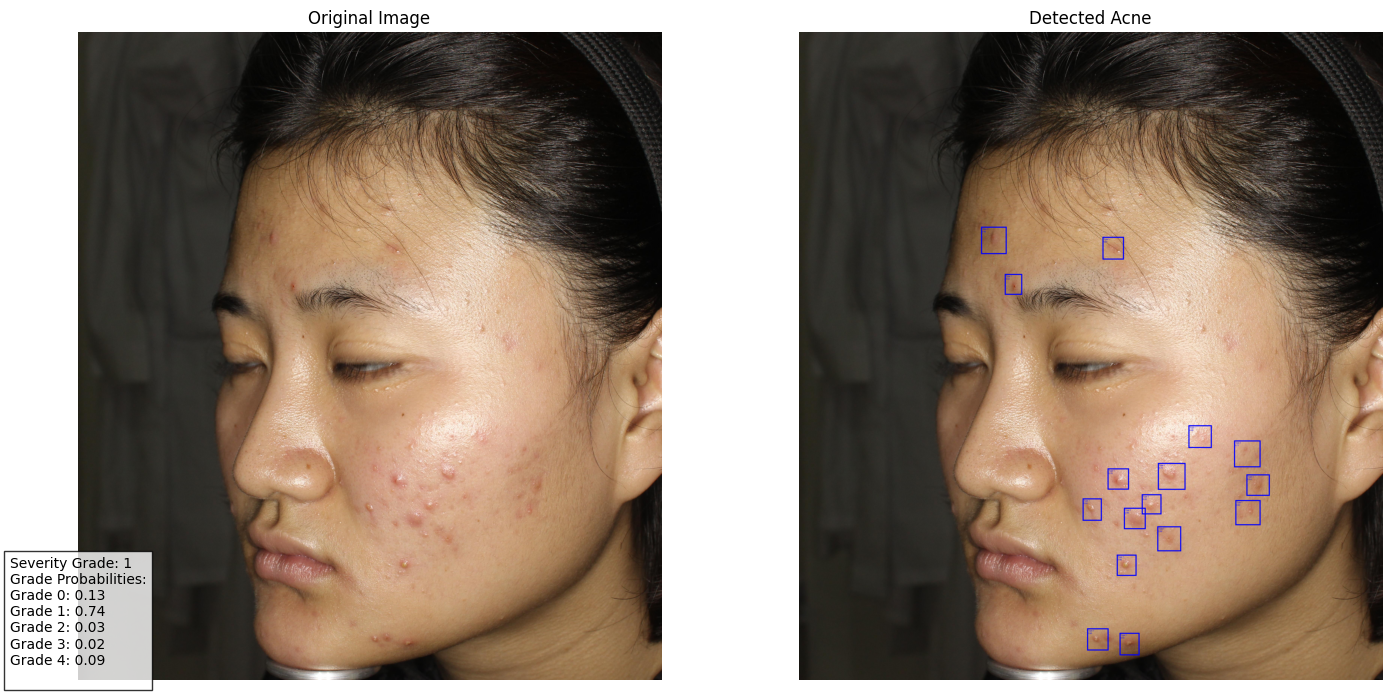


Detection Summary:
Total detections: 16
Type 1: confidence = 0.9465
Type 1: confidence = 0.9310
Type 1: confidence = 0.8954
Type 1: confidence = 0.8874
Type 1: confidence = 0.8805
Type 1: confidence = 0.8729
Type 1: confidence = 0.8648
Type 1: confidence = 0.8578
Type 1: confidence = 0.8543
Type 1: confidence = 0.8363
Type 1: confidence = 0.7997
Type 1: confidence = 0.7796
Type 1: confidence = 0.7535
Type 1: confidence = 0.7140
Type 1: confidence = 0.6816
Type 1: confidence = 0.5961

Severity Analysis:
Predicted Severity Grade: 1

Grade Probabilities:
Grade 0: 0.1344
Grade 1: 0.7351
Grade 2: 0.0272
Grade 3: 0.0179
Grade 4: 0.0854


In [70]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
import numpy as np
import joblib

def process_single_image(image_path, detection_model, grading_model, device, confidence_threshold=0.5):
    """
    Process a single image through both detection and severity grading models
    
    Args:
        image_path: Path to the input image
        detection_model: Trained Faster R-CNN model
        grading_model: Trained LightGBM severity grading model
        device: torch device
        confidence_threshold: Minimum confidence score for detections
    """
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Get detections
    detection_model.eval()
    with torch.no_grad():
        detections = detection_model(image_tensor)[0]  # Get first (and only) image results
        
    # Filter by confidence
    mask = detections['scores'] > confidence_threshold
    boxes = detections['boxes'][mask]
    scores = detections['scores'][mask]
    labels = detections['labels'][mask]
    
    # Prepare image for visualization
    image_tensor = image_tensor.squeeze(0).cpu()
    
    # Draw boxes
    colors = ['red', 'blue', 'green', 'yellow']  # Different colors for different acne types
    box_colors = [colors[label.item() % len(colors)] for label in labels]
    
    # Create labels with scores
    box_labels = [f"Type {label.item()}\n{score:.2f}" 
                 for label, score in zip(labels, scores)]
    
    image_with_boxes = draw_bounding_boxes(
        (image_tensor * 255).to(torch.uint8),
        boxes,
        labels=box_labels,
        colors=box_colors,
        width=6,
        font_size=30
    )
    
    # Convert for display
    image_with_boxes = image_with_boxes.permute(1, 2, 0).numpy()
    
    # Get severity prediction
    detection_result = [{
        'boxes': boxes,
        'scores': scores,
        'labels': labels
    }]
    
    severity_grade = grading_model.predict(detection_result)[0]
    severity_probs = grading_model.predict_proba(detection_result)[0]
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Image with detections
    ax2.imshow(image_with_boxes)
    ax2.set_title('Detected Acne')
    ax2.axis('off')
    
    # Add severity information
    severity_text = f'Severity Grade: {severity_grade}\n'
    severity_text += 'Grade Probabilities:\n'
    for grade, prob in enumerate(severity_probs):
        severity_text += f'Grade {grade}: {prob:.2f}\n'
    
    plt.figtext(0.02, 0.02, severity_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print detection summary
    print("\nDetection Summary:")
    print(f"Total detections: {len(boxes)}")
    for label, score in zip(labels, scores):
        print(f"Type {label.item()}: confidence = {score:.4f}")
    
    print("\nSeverity Analysis:")
    print(f"Predicted Severity Grade: {severity_grade}")
    print("\nGrade Probabilities:")
    for grade, prob in enumerate(severity_probs):
        print(f"Grade {grade}: {prob:.4f}")
    
    return {
        'boxes': boxes,
        'scores': scores,
        'labels': labels,
        'severity_grade': severity_grade,
        'severity_probabilities': severity_probs
    }

# Example usage
if __name__ == "__main__":
    # Load models
    detection_model = get_fasterrcnn_model(num_classes=5)
    checkpoint = torch.load('acne_detection_results/checkpoints/model_final.pth')
    detection_model.load_state_dict(checkpoint['model_state_dict'])
    
    grading_model = AcneSeverityGrading()
    grading_model.load_model('acne_severity_model.joblib')
    
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    detection_model = detection_model.to(device)
    
    # Process a sample image
    image_path = 'acne04-dataset/Classification/Classification/JPEGImages/levle2_118.jpg'

    results = process_single_image(
        image_path=image_path,
        detection_model=detection_model,
        grading_model=grading_model,
        device=device,
        confidence_threshold=0.5  # Adjust this threshold as needed
    )

Metrics

Detection Metrics:

In [148]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, confusion_matrix, classification_report
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# Constants
ACNE_TYPES = ['Blackheads/Whiteheads', 'Papules/Pustules', 'Nodules/Cysts', 'Acne Scars']
COLORS = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True


# Create test dataset
test_dataset = AcneDataset(
    images_dir='acne04-dataset/Classification/Classification/JPEGImages',
    xml_dir='acne04-dataset/Detection/Detection/VOC2007/Annotations',
    label_files=['acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_test_0.txt',
                 'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_test_1.txt',
                 'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_test_2.txt',
                 'acne04-dataset/Detection/Detection/VOC2007/ImageSets/Main/NNEW_test_3.txt'],
    transform=transforms.ToTensor()
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: tuple(zip(*x))
)

In [149]:
# Make sure model is in eval mode
model.eval()

detection_results = []
true_labels = []

with torch.no_grad():
    for images, targets in test_loader:
        # Move images to device
        images = [img.to(device) for img in images]
        
        # Get model predictions
        preds = model(images)
        detection_results.extend(preds)
        true_labels.extend(targets)

# Calculate metrics
metrics_per_class = []
for class_id in range(4):  # 4 acne types
    class_preds = [pred['boxes'][pred['labels'] == class_id] for pred in detection_results]
    class_scores = [pred['scores'][pred['labels'] == class_id] for pred in detection_results]
    
    tp = 0
    fp = 0
    fn = 0
    
    for pred_boxes, target in zip(class_preds, true_labels):
        target_boxes = target['boxes'][target['labels'] == class_id]
        
        if len(pred_boxes) > 0 and len(target_boxes) > 0:
            tp += len(pred_boxes)
        elif len(pred_boxes) > 0:
            fp += len(pred_boxes)
        elif len(target_boxes) > 0:
            fn += len(target_boxes)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_per_class.append({
        'Class': ACNE_TYPES[class_id],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'TP': tp,
        'FP': fp,
        'FN': fn
    })

detection_metrics = pd.DataFrame(metrics_per_class)
print("\nDetection Metrics:")
print(detection_metrics)


Detection Metrics:
                   Class  Precision  Recall        F1     TP    FP   FN
0  Blackheads/Whiteheads   0.000000     0.0  0.000000      0     0  863
1       Papules/Pustules   0.694797     1.0  0.819918  17174  7544    0
2          Nodules/Cysts   0.482352     1.0  0.650793   7120  7641    0
3             Acne Scars   0.670172     1.0  0.802519   7965  3920    0


Severity Grading Metrics:

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import torch

# Get predictions and true labels
severity_preds = []
severity_probs = []
severity_true = []

def criterion(lesions_num):
    """Calculate severity grade based on lesion count"""
    lesions_num = int(lesions_num)
    if lesions_num <= 5:
        return 0  # Clear skin
    elif lesions_num <= 15:
        return 1  # Almost clear
    elif lesions_num <= 25:
        return 2  # Mild severity
    elif lesions_num <= 45:
        return 3  # Moderate severity
    else:
        return 4  # Severe

# Get predictions
model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = [img.to(device) for img in images]
        detections = model(images)
        
        formatted_detections = [{
            'boxes': det['boxes'].cpu(),
            'labels': det['labels'].cpu(),
            'scores': det['scores'].cpu()
        } for det in detections]
        
        # Get both predictions and probabilities
        preds = grading_model.predict(formatted_detections)
        probs = grading_model.predict_proba(formatted_detections)
        
        severity_preds.extend(preds)
        severity_probs.extend(probs)
        severity_true.extend([criterion(len(t['boxes'])) for t in targets])

# Convert to numpy arrays
severity_true = np.array(severity_true)
severity_preds = np.array(severity_preds)
severity_probs = np.array(severity_probs)



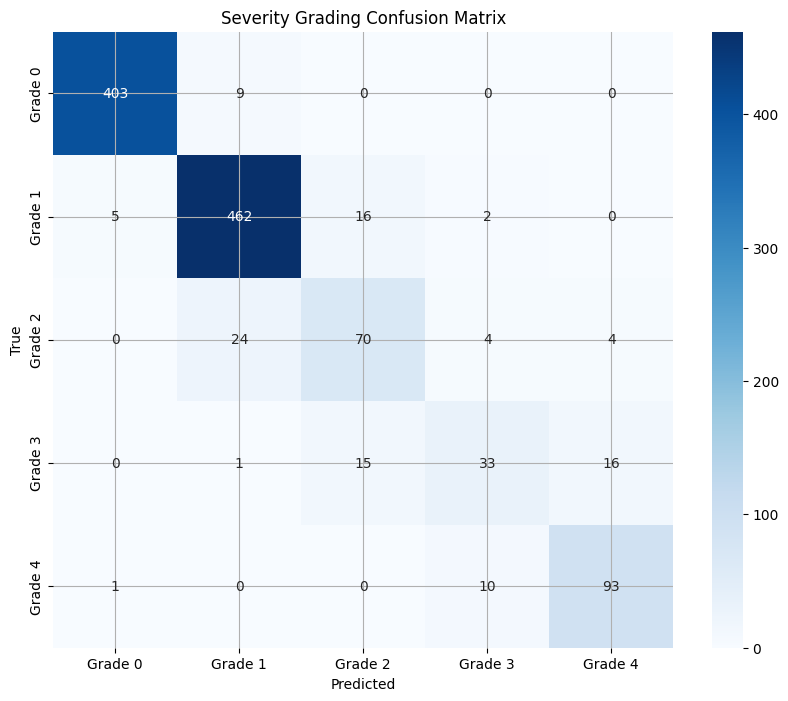

In [138]:
# 1. Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(severity_true, severity_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Grade {i}' for i in range(5)],
            yticklabels=[f'Grade {i}' for i in range(5)])
plt.title('Severity Grading Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()



In [139]:
# 2. Classification Report
print("\nClassification Report:")
print(classification_report(severity_true, severity_preds, 
                          target_names=[f'Grade {i}' for i in range(5)]))




Classification Report:
              precision    recall  f1-score   support

     Grade 0       0.99      0.98      0.98       412
     Grade 1       0.93      0.95      0.94       485
     Grade 2       0.69      0.69      0.69       102
     Grade 3       0.67      0.51      0.58        65
     Grade 4       0.82      0.89      0.86       104

    accuracy                           0.91      1168
   macro avg       0.82      0.80      0.81      1168
weighted avg       0.91      0.91      0.91      1168



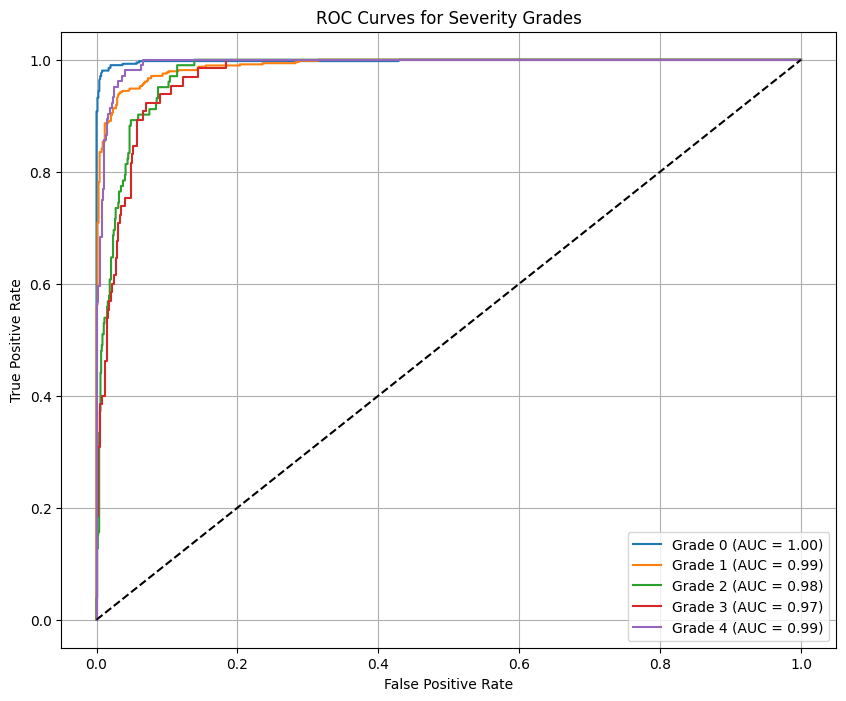

In [140]:
# 3. ROC Curves
plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve((severity_true == i).astype(int), severity_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Grade {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Severity Grades')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()